# Fine-Tuning Vision Models for Ear Infection Classification

1. **Dataset Setup**
2. **Data Preprocessing**
3. **Model Selection**
4. **Lightning Module Setup**
5. **Training Configuration**
6. **Model Training**
7. **Model Evaluation**
8. **Prediction & Visualization**
9. **Save & Load Model**
10. **Deployment**

## TOB

1. **Dataset Setup**
   - Download the dataset from Kaggle.
   - Clean old files and unpack the dataset.
   - Exclude low-sample classes.
   - Split data into `train/`, `val/`, and `test/` folders.

2. **Data Preprocessing**
   - Define image transforms for training and evaluation.
   - Use `torchvision.datasets.ImageFolder` for loading images.
   - Create `DataLoader`s for training, validation, and testing.

3. **Model Selection**
   - Use `timm` to load a pre-trained EfficientNetV2 model (`tf_efficientnetv2_s.in21k`).
   - Replace the classification head to match your dataset’s number of classes.

4. **Choosing the Right Evaluation Metric**
   - Use macro-averaged `F1-score` as the primary metric due to class imbalance.

5. **Lightning Module Setup for EfficientNetV2 with F1 Scoring**
   - Define a `LightningModule` with:
     - `forward()`
     - `training_step()`, `validation_step()`, `test_step()`
     - `configure_optimizers()`
     - Integrated macro F1 score for validation and test steps.

6. **Training Multiple Fine-Tuning Strategies**
   - Apply strategies: `freeze_backbone`, `last1+head`, `last2+head`, `last3+head`, `last4+head`, `full`.
   - Use `MLflow` to log metrics and parameters.
   - Apply `EarlyStopping` and `ModelCheckpoint` during training.
   - Use `Trainer` to run each training strategy.

7. **Model Evaluation on Test Dataset**
   - Evaluate each saved checkpoint using the test set.
   - Print classification report and show confusion matrix.

8. **Fine-Tuning Strategy Evaluation Summary**
   - Tabulate and compare accuracy, precision, recall, and F1 scores for all strategies.

9. **Model Improvement Strategies**
   - Add learning rate tuning, experiment with optimizers, or balance dataset.

10. **Training Multiple Fine-Tuning Strategies with LR Tuning**
    - Tune learning rate for each strategy using `Tuner`.
    - Re-train models with best learning rates.

11. **Model Evaluation after Learning Rate Tuning on Test Dataset**
    - Evaluate test performance of LR-tuned models.

12. **Fine-Tuning Strategy Evaluation Summary (After LR Tuning)**
    - Compare metrics post-learning rate optimization.

13. **Model Evaluation (F1 Score) for Each Class**
    - Display per-class F1 score on test dataset.

14. **F1 Score for Individual Class Analysis and Conclusion**
    - Analyze strong and weak classes based on F1 score.

15. **Cycle 2: Dataset Setup with 5 Excluded Classes**
    - Rebuild dataset with only 4 key classes:
      - `Aom`, `Chronic`, `Earwax`, `Normal`

16. **Cycle 2: Training Multiple Fine-Tuning Strategies**
    - Repeat training process for reduced class dataset.

17. **Cycle 2: Model Evaluation**
    - Evaluate best checkpoints from Cycle 2.

18. **Upload the Best Checkpoint to Google Drive**
    - Save best `.ckpt` file for deployment or sharing.

In [1]:
# Install packages

!pip install --upgrade -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 1.1 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 1.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 1.1 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1
  Attempting uninstall: huggingface_hub
    Found existing installatio

In [15]:
# Standard Library
import glob
import json
import os
import random
import shutil
import time
import zipfile
from pathlib import Path

# Image Processing & Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch Core
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader

# Torchvision
from torchvision import datasets, transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.tuner.tuning import Tuner

# MLFlow
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

# Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

# Hugging Face / Model Libraries
import timm

# Google Drive API
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Default Device
device = torch.device("cpu")

## 1. Dataset Setup

Removing old extracted dataset...
Removing old split dataset...
Found existing zip file. Skipping download.
Unzipping dataset...
Dataset extracted to /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/eardrum_dataset

Original class distribution (before exclusion):
  OtitExterna: 41 images
  tympanoskleros: 28 images
  Aom: 119 images
  Earventulation: 16 images
  Earwax: 140 images
  PseduoMembran: 11 images
  Normal: 534 images
  Foreign: 3 images
  Chornic: 63 images

Dataset organized and split into train/val/test folders.
Excluded classes: 'Foreign', 'PseduoMembran', and 'Earventulation'

Image count per class (after split):

Split: train
  OtitExterna: 28 images
  tympanoskleros: 19 images
  Aom: 83 images
  Earwax: 98 images
  Normal: 373 images
  Chornic: 44 images

Split: val
  OtitExterna: 6 images
  tympanoskleros: 4 images
  Aom: 17 images
  Earwax: 21 images
  Normal: 80 images
  Chornic: 9 images

Split: test
  OtitExterna: 7 images
  tympanoskleros: 5 image

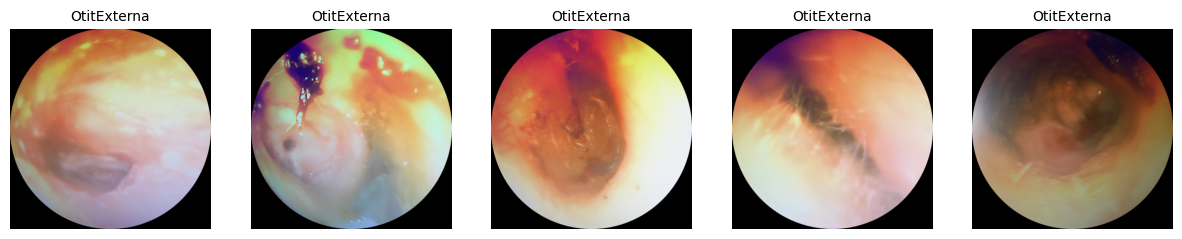


Class: tympanoskleros


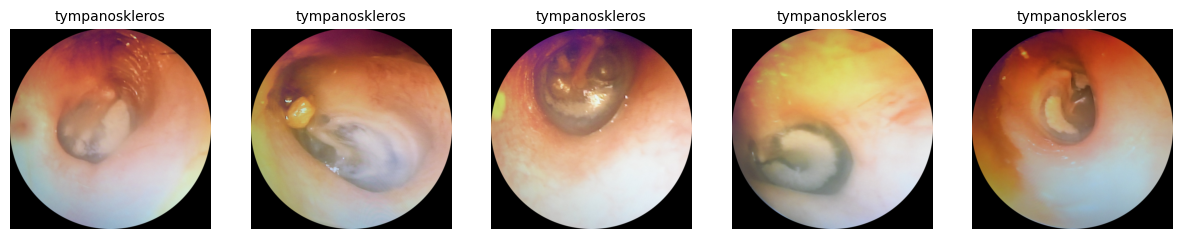


Class: Aom


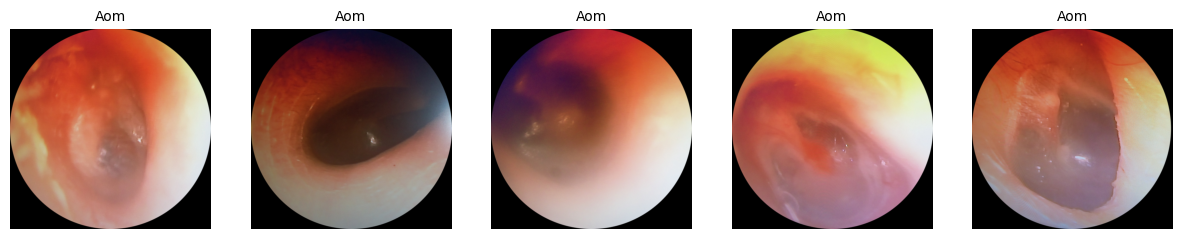


Class: Earwax


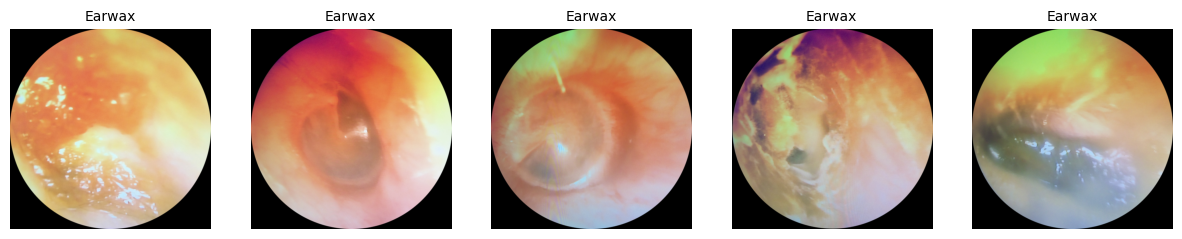


Class: Normal


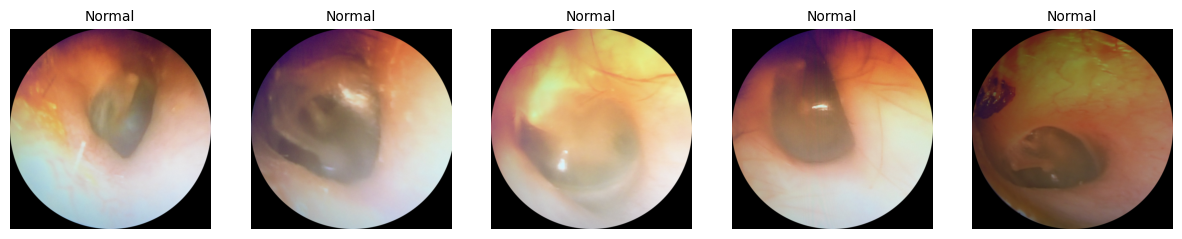


Class: Chornic


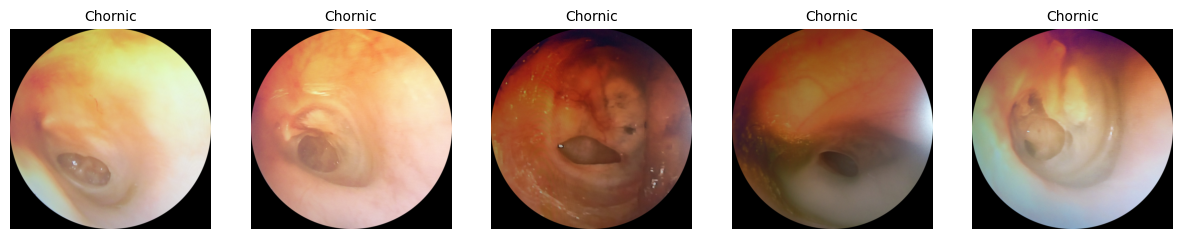

In [16]:
# ------------------- Block 0: Download & Unpack Dataset -------------------
def download_and_unpack_kaggle_dataset():
    kaggle_dataset = "erdalbasaran/eardrum-dataset-otitis-media"
    zip_file = Path("eardrum-dataset-otitis-media.zip")
    extract_dir = Path("eardrum_dataset")

    # Clean up old data
    if extract_dir.exists():
        print("Removing old extracted dataset...")
        shutil.rmtree(extract_dir)

    if Path("eardrum_split").exists():
        print("Removing old split dataset...")
        shutil.rmtree("eardrum_split")

    # Download if not present
    if not zip_file.exists():
        print("Downloading dataset from Kaggle...")
        os.system(f'kaggle datasets download -d {kaggle_dataset}')
    else:
        print("Found existing zip file. Skipping download.")

    # Unzip
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted to {extract_dir.resolve()}")

download_and_unpack_kaggle_dataset()

# ------------------- Block 1: Setup -------------------
random.seed(42)

src_dir = Path("eardrum_dataset/eardrumDs")  # Extracted dataset directory
base_dir = Path('eardrum_split')   # Output for train/val/test split
splits = ['train', 'val', 'test']
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

print("\nOriginal class distribution (before exclusion):")
all_classes = [d for d in src_dir.iterdir() if d.is_dir()]
for cls_dir in all_classes:
    count = len(list(cls_dir.glob("*")))
    print(f"  {cls_dir.name}: {count} images")

# Exclude small classes
excluded_classes = {'Foreign', 'PseduoMembran', 'Earventulation'}
classes = [d.name for d in src_dir.iterdir() if d.is_dir() and d.name not in excluded_classes]

# Create split folders
for split in splits:
    for cls in classes:
        os.makedirs(base_dir / split / cls, exist_ok=True)

# ------------------- Block 2: Split the dataset -------------------
for cls in classes:
    images = list((src_dir / cls).glob('*'))
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_files = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, files in split_files.items():
        for img in files:
            dest = base_dir / split / cls / img.name
            shutil.copy(img, dest)

print("\nDataset organized and split into train/val/test folders.")
print("Excluded classes: 'Foreign', 'PseduoMembran', and 'Earventulation'\n")

# ------------------- Block 3: Display image counts after split -------------------
print("Image count per class (after split):")
for split in splits:
    print(f"\nSplit: {split}")
    for cls in classes:
        class_path = base_dir / split / cls
        count = len(list(class_path.glob('*')))
        print(f"  {cls}: {count} images")

# ------------------- Block 4: Show sample images -------------------
def show_images_per_class(split="train", num_images=5):
    print(f"\nShowing {num_images} images per class from '{split}':")
    class_dirs = list((base_dir / split).glob('*'))
    for cls_dir in class_dirs:
        image_paths = list(cls_dir.glob("*"))
        if not image_paths:
            continue
        selected_images = random.sample(image_paths, min(num_images, len(image_paths)))
        print(f"\nClass: {cls_dir.name}")
        plt.figure(figsize=(15, 3))
        for i, img_path in enumerate(selected_images):
            img = Image.open(img_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls_dir.name, fontsize=10)
        plt.show()

# Show training samples
show_images_per_class("train")

## 2. Data Preprocessing

In [25]:
def get_dataloaders(data_dir='eardrum_split', image_size=224, batch_size=32, num_workers=4):
    """
    Returns DataLoaders and datasets for training, validation, and testing.

    Returns:
        train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset
    """
    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Datasets
    train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=train_transform)
    val_dataset   = datasets.ImageFolder(root=f'{data_dir}/val', transform=val_test_transform)
    test_dataset  = datasets.ImageFolder(root=f'{data_dir}/test', transform=val_test_transform)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

## 3. Model Selection

In [10]:
# List all model names that support pretrained=True
pretrained_models = timm.list_models(pretrained=True)

# Print the first few
for model in pretrained_models[:10]:
    print(model)

aimv2_1b_patch14_224.apple_pt
aimv2_1b_patch14_336.apple_pt
aimv2_1b_patch14_448.apple_pt
aimv2_3b_patch14_224.apple_pt
aimv2_3b_patch14_336.apple_pt
aimv2_3b_patch14_448.apple_pt
aimv2_huge_patch14_224.apple_pt
aimv2_huge_patch14_336.apple_pt
aimv2_huge_patch14_448.apple_pt
aimv2_large_patch14_224.apple_pt


In [11]:
# Load pretrained model in backbone (feature-only) mode
model = timm.create_model(
    "tf_efficientnetv2_s.in21k",
    pretrained=True,
    features_only=True
)

# Number of feature blocks (scales)
num_blocks = len(model.feature_info)
print("Number of feature blocks:", num_blocks)

# Optionally, print out channels and module names
print("Feature channels per block:", model.feature_info.channels())
print("Module names:", model.feature_info.module_name())

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Number of feature blocks: 5
Feature channels per block: [24, 48, 64, 160, 256]
Module names: ['blocks.0', 'blocks.1', 'blocks.2', 'blocks.4', 'blocks.5']


## 4. Choosing the Right Evaluation Metric

In this eardrum classification task, **F1 Score** is the **most important evaluation metric**, followed by Recall.

- **F1 Score** is our primary metric because it balances both **Precision** and **Recall**, which is essential in medical image classification where **both false positives and false negatives carry clinical consequences**.
- We specifically use **Macro F1 Score**, which calculates F1 for each class independently and then averages them.
- **Recall** is also a high priority, as **missing a true positive (false negative)** could delay treatment or cause a missed diagnosis — especially harmful in cases like **Acute Otitis Media** or **Chronic Otitis Media**.
- While **Precision** matters too (to reduce false positives and unnecessary follow-ups), it is **secondary** in our priority compared to Recall.
- **Accuracy** is not a reliable metric in this context due to **class imbalance**, where dominant classes (like `Normal`) can inflate the score while the model underperforms on minority classes.

**Summary**:  
We prioritize **Macro F1 Score** because it provides a fair, reliable measure of model performance across all classes, especially in a medical setting where **every diagnosis matters**.

## 5. Lightning Module Setup for EfficientNetV2 with F1 Scoring

In [17]:
class EfficientNetV2Lightning(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = timm.create_model("tf_efficientnetv2_s.in21k", pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss)
        self.log("val_f1", f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.test_f1(preds, y)
        self.log("test_loss", loss)
        self.log("test_f1", f1, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

## 6. Training Multiple Fine-Tuning Strategies

In [32]:
seed_everything(42, workers=True)

# === Fine-tuning strategy setup ===
def set_finetune_strategy(model, strategy):
    if strategy == "freeze_backbone":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last1+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-1].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last2+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-2:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last3+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-3:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "last4+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-4:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True

    elif strategy == "full":
        for param in model.model.parameters():
            param.requires_grad = True


# === Run training for all strategies ===
if __name__ == "__main__":
    strategies = [
        "freeze_backbone", "last1+head", "last2+head",
        "last3+head", "last4+head", "full"
    ]

    num_classes = len(train_dataset.classes)
    best_ckpt_paths = {}

    for strategy in strategies:
        print(f"\nTraining strategy: {strategy}")

        # Initialize model and set fine-tuning strategy
        model = EfficientNetV2Lightning(num_classes=num_classes)
        set_finetune_strategy(model, strategy)

        # MLflow logger
        mlflow_logger = MLFlowLogger(
            experiment_name="eardrum_finetune_strategies",
            tracking_uri="file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns",
            run_name=strategy
        )

        # Callbacks
        early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
        checkpoint = ModelCheckpoint(
            monitor="val_f1",
            mode="max",
            save_top_k=1,
            filename=f"{strategy}-best-f1-{{epoch:02d}}-{{val_f1:.4f}}"
        )

        # Trainer
        trainer = Trainer(
            max_epochs=20,
            accelerator="auto",
            precision="16-mixed",
            callbacks=[early_stop, checkpoint],
            logger=mlflow_logger
        )

        # Train model
        trainer.fit(model, train_loader, val_loader)

        # Save best checkpoint path
        ckpt_path = checkpoint.best_model_path
        print(f"Best checkpoint for '{strategy}' saved at: {ckpt_path}")
        best_ckpt_paths[strategy] = ckpt_path

        # Log checkpoint file
        mlflow_logger.experiment.log_artifact(mlflow_logger.run_id, ckpt_path)

        # Log model with input example
        example_input = torch.randn(1, 3, 224, 224).numpy()
        with mlflow.start_run(run_id=mlflow_logger.run_id):
            mlflow.pytorch.log_model(
                model,
                artifact_path="model",
                input_example=example_input
            )

    # Save all best checkpoint paths to JSON
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    json_path = f"best_checkpoints_{timestamp}.json"
    with open(json_path, "w") as f:
        json.dump(best_ckpt_paths, f)
    print(f"Saved best checkpoint paths to {json_path}")

Seed set to 42



Training strategy: freeze_backbone


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
7.7 K     Trainable params
20.2 M    Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/30 12:48:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'freeze_backbone' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f325781600564235a5a630dfe3bd7914/checkpoints/freeze_backbone-best-f1-epoch=15-val_f1=0.1716.ckpt

Training strategy: last1+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
14.6 M    Trainable params
5.6 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Best checkpoint for 'last1+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/b65caf1122ca4a89b6c7f48f8f47f26e/checkpoints/last1+head-best-f1-epoch=11-val_f1=0.3534.ckpt


2025/07/30 12:59:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Training strategy: last2+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
18.0 M    Trainable params
2.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/30 13:06:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last2+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/2ce0ce2d343841ccb0575679144d83b4/checkpoints/last2+head-best-f1-epoch=05-val_f1=0.3454.ckpt

Training strategy: last3+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.0 M    Trainable params
1.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/30 13:16:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last3+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e796d88e27bf4a61972203572aef23ba/checkpoints/last3+head-best-f1-epoch=07-val_f1=0.4082.ckpt

Training strategy: last4+head


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.5 M    Trainable params
644 K     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/30 13:26:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last4+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/c5e393a336c04cb09e4a367249a1d290/checkpoints/last4+head-best-f1-epoch=04-val_f1=0.3470.ckpt

Training strategy: full


Using 16bit Automatic Mixed Precision (AMP)
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

2025/07/30 13:35:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'full' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/40e9ddc1463249bfb6e68b274bd4e523/checkpoints/full-best-f1-epoch=06-val_f1=0.3286.ckpt
Saved best checkpoint paths to best_checkpoints_20250730-133533.json


## 7. Model Evaluation on Test Dataset

Seed set to 42



Loading latest checkpoint file: best_checkpoints_20250730-133533.json

Evaluating strategy: freeze_backbone
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f325781600564235a5a630dfe3bd7914/checkpoints/freeze_backbone-best-f1-epoch=15-val_f1=0.1716.ckpt

Accuracy:  0.3007
Precision: 0.2131
Recall:    0.2004
F1 Score:  0.1907

Classification Report:
                precision    recall  f1-score   support

           Aom       0.17      0.26      0.21        19
       Chornic       0.00      0.00      0.00        10
        Earwax       0.18      0.38      0.25        21
        Normal       0.67      0.36      0.47        81
   OtitExterna       0.00      0.00      0.00         7
tympanoskleros       0.25      0.20      0.22         5

      accuracy                           0.30       143
     macro avg       0.21      0.20      0.19       143
  weighted avg       0.44      0.30      0.34       143



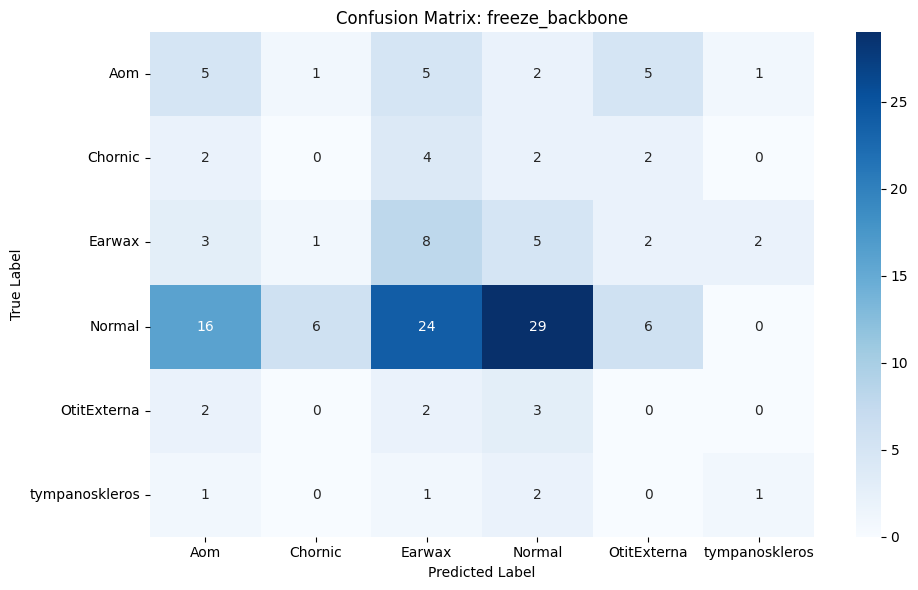


Evaluating strategy: last1+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/b65caf1122ca4a89b6c7f48f8f47f26e/checkpoints/last1+head-best-f1-epoch=11-val_f1=0.3534.ckpt

Accuracy:  0.6713
Precision: 0.5411
Recall:    0.4843
F1 Score:  0.5015

Classification Report:
                precision    recall  f1-score   support

           Aom       0.37      0.53      0.43        19
       Chornic       0.67      0.40      0.50        10
        Earwax       0.73      0.52      0.61        21
        Normal       0.80      0.83      0.81        81
   OtitExterna       0.43      0.43      0.43         7
tympanoskleros       0.25      0.20      0.22         5

      accuracy                           0.67       143
     macro avg       0.54      0.48      0.50       143
  weighted avg       0.69      0.67      0.67       143



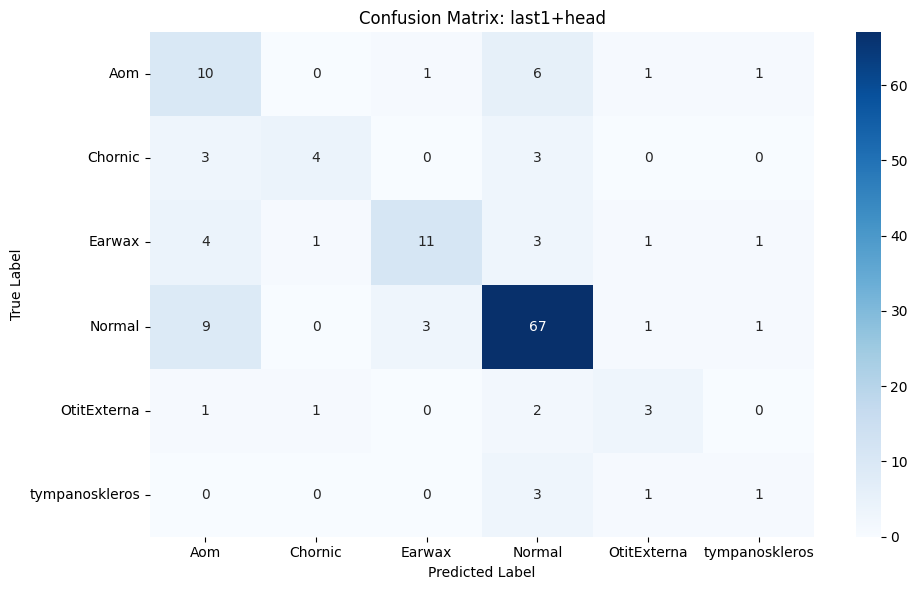


Evaluating strategy: last2+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/2ce0ce2d343841ccb0575679144d83b4/checkpoints/last2+head-best-f1-epoch=05-val_f1=0.3454.ckpt

Accuracy:  0.7273
Precision: 0.5214
Recall:    0.4737
F1 Score:  0.4900

Classification Report:
                precision    recall  f1-score   support

           Aom       0.58      0.37      0.45        19
       Chornic       0.38      0.30      0.33        10
        Earwax       0.70      0.76      0.73        21
        Normal       0.82      0.93      0.87        81
   OtitExterna       0.40      0.29      0.33         7
tympanoskleros       0.25      0.20      0.22         5

      accuracy                           0.73       143
     macro avg       0.52      0.47      0.49       143
  weighted avg       0.70      0.73      0.71       143



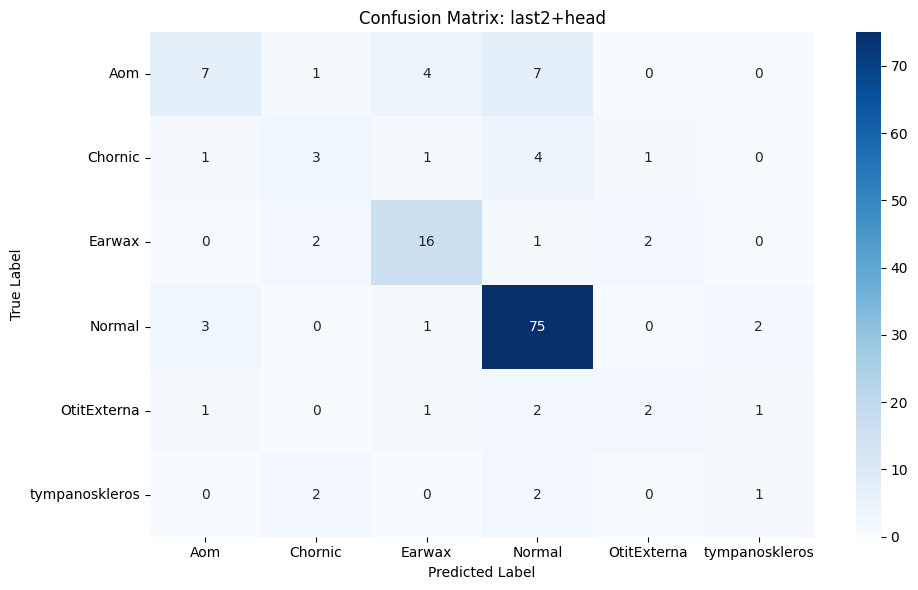


Evaluating strategy: last3+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e796d88e27bf4a61972203572aef23ba/checkpoints/last3+head-best-f1-epoch=07-val_f1=0.4082.ckpt

Accuracy:  0.7063
Precision: 0.6488
Recall:    0.5222
F1 Score:  0.5672

Classification Report:
                precision    recall  f1-score   support

           Aom       0.45      0.47      0.46        19
       Chornic       0.60      0.30      0.40        10
        Earwax       0.82      0.67      0.74        21
        Normal       0.75      0.86      0.80        81
   OtitExterna       0.60      0.43      0.50         7
tympanoskleros       0.67      0.40      0.50         5

      accuracy                           0.71       143
     macro avg       0.65      0.52      0.57       143
  weighted avg       0.70      0.71      0.70       143



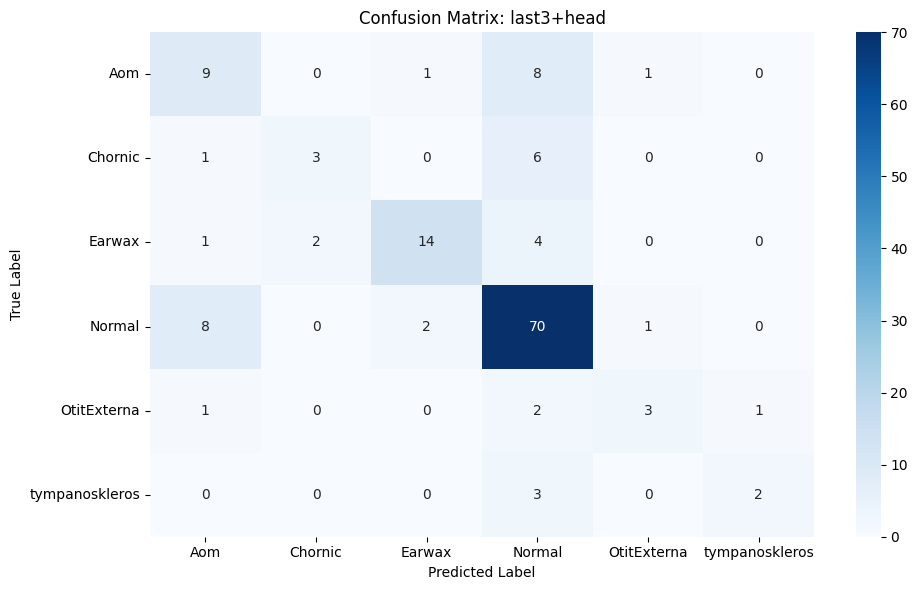


Evaluating strategy: last4+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/c5e393a336c04cb09e4a367249a1d290/checkpoints/last4+head-best-f1-epoch=04-val_f1=0.3470.ckpt

Accuracy:  0.6783
Precision: 0.5527
Recall:    0.5017
F1 Score:  0.5172

Classification Report:
                precision    recall  f1-score   support

           Aom       0.41      0.47      0.44        19
       Chornic       0.60      0.30      0.40        10
        Earwax       0.74      0.67      0.70        21
        Normal       0.77      0.83      0.80        81
   OtitExterna       0.20      0.14      0.17         7
tympanoskleros       0.60      0.60      0.60         5

      accuracy                           0.68       143
     macro avg       0.55      0.50      0.52       143
  weighted avg       0.67      0.68      0.67       143



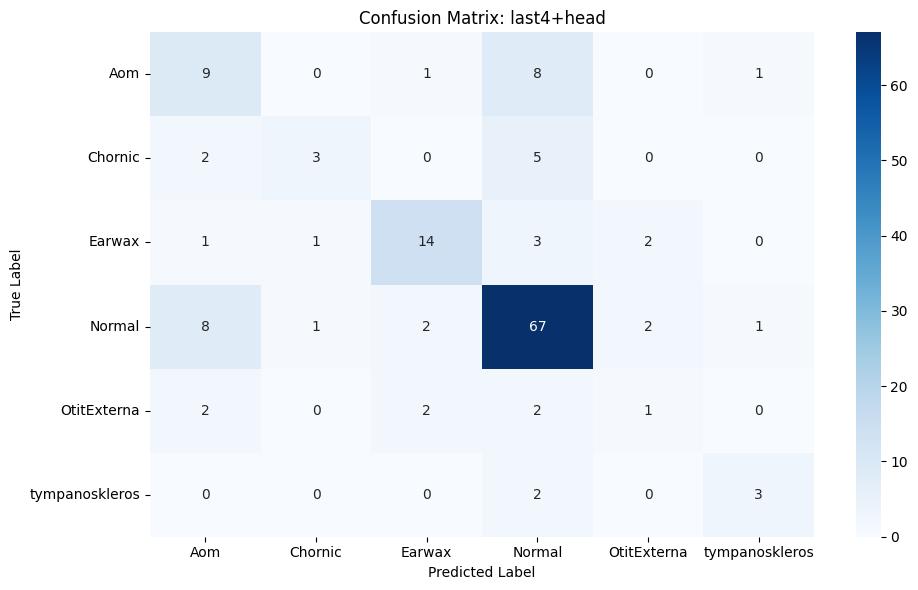


Evaluating strategy: full
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/40e9ddc1463249bfb6e68b274bd4e523/checkpoints/full-best-f1-epoch=06-val_f1=0.3286.ckpt

Accuracy:  0.6713
Precision: 0.5309
Recall:    0.4466
F1 Score:  0.4649

Classification Report:
                precision    recall  f1-score   support

           Aom       0.62      0.26      0.37        19
       Chornic       0.36      0.40      0.38        10
        Earwax       0.67      0.67      0.67        21
        Normal       0.74      0.86      0.80        81
   OtitExterna       0.29      0.29      0.29         7
tympanoskleros       0.50      0.20      0.29         5

      accuracy                           0.67       143
     macro avg       0.53      0.45      0.46       143
  weighted avg       0.66      0.67      0.65       143



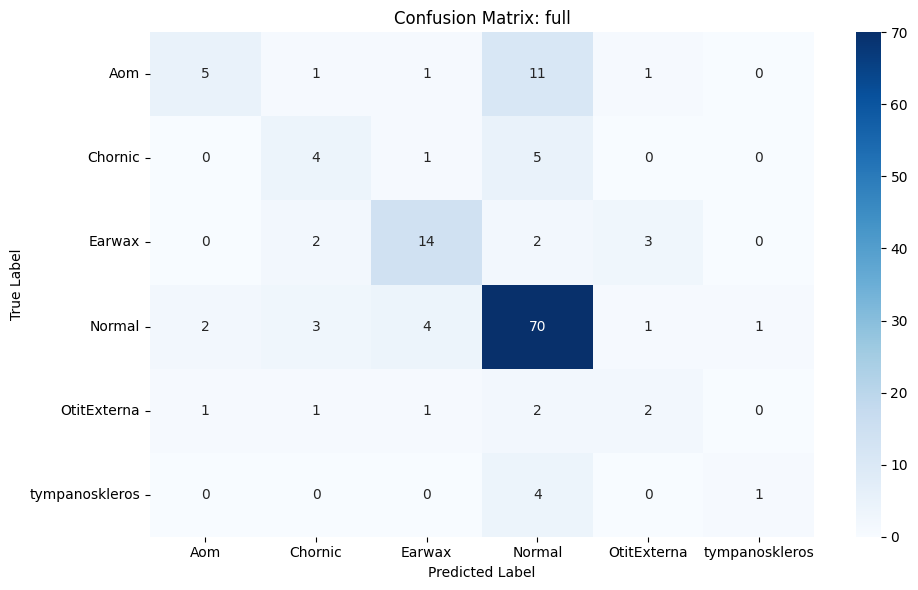

In [33]:
seed_everything(42, workers=True)

# Set MLflow tracking
tracking_uri = "file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("eardrum_finetune_strategies")

def evaluate_model(strategy, ckpt_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"\nEvaluating strategy: {strategy}")
    print("Using device:", device)
    print("Loaded checkpoint:", ckpt_path)

    # Load model
    model = EfficientNetV2Lightning.load_from_checkpoint(ckpt_path)
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:")
    report_txt = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    print(report_txt)

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {strategy}")
    plt.tight_layout()
    plt.show()

    # MLflow logging
    with mlflow.start_run(run_name=f"eval_{strategy}", nested=True):
        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1", f1)

        # Save and log classification report
        report_path = f"classification_report_{strategy}.txt"
        with open(report_path, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(report_path)

        # Also log the checkpoint used
        mlflow.log_artifact(ckpt_path)

# === Load latest checkpoint file ===
import glob
import os
import json

checkpoint_files = glob.glob("best_checkpoints_*.json")
if not checkpoint_files:
    raise FileNotFoundError("No best_checkpoints_*.json files found.")

latest_ckpt_file = max(checkpoint_files, key=os.path.getmtime)
print(f"\nLoading latest checkpoint file: {latest_ckpt_file}")

with open(latest_ckpt_file, "r") as f:
    best_ckpt_paths = json.load(f)

# === Evaluate all saved strategies ===
for strategy, ckpt_path in best_ckpt_paths.items():
    evaluate_model(strategy, ckpt_path)

## 8. Fine-Tuning Strategy Evaluation Summary

| Strategy           | Accuracy | Precision | Recall  | F1 Score |
|-------------------|----------|-----------|---------|----------|
| `freeze_backbone` | 0.3007   | 0.2131    | 0.2004  | 0.1907   |
| `last1+head`      | 0.6713   | 0.5411    | 0.4843  | 0.5015   |
| `last2+head`      | 0.7273   | 0.5214    | 0.4737  | 0.4900   |
| `last3+head`      | 0.7063   | **0.6488**| **0.5222**  | **0.5672**   |
| `last4+head`      | 0.6783   | 0.5527    | 0.5017  | 0.5172   |
| `full`            | 0.6713   | 0.5309    | 0.4466  | 0.4649   |

**Best Strategy: `last3+head`**

- Based on **F1 Score (0.5672)**, which is our project's **primary metric** due to class imbalance and the high cost of misclassifying medical conditions, `last3+head` is the most effective fine-tuning strategy.
- It also achieves the **highest Precision (0.6488)** and **strong Recall (0.5222)**, making it the most balanced model in detecting true cases of ear diseases.
- This strategy offers the best trade-off between under- and over-diagnosis, supporting its use in real-world medical decision systems.

*Checkpoint file evaluated: `last3+head-best-f1-epoch=07-val_f1=0.4082.ckpt` (Seed = 42)*

## 9. Model Improvement Strategies

List of possible improvemnets:

- Tuning the learning rate (`lr`)
- Increasing `max_epochs`
- Applying stronger data augmentation
- Addressing class imbalance (e.g., oversampling minority classes)
- Trying alternative loss functions (like `FocalLoss` or class-weighted `CrossEntropyLoss`) to penalize misclassifications more effectively

## 10. Training Multiple Fine-Tuning Strategies with LR Tuning

In [9]:
class EfficientNetV2Lightning(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = timm.create_model("tf_efficientnetv2_s.in21k", pretrained=True, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.val_f1(preds, y)
        self.log("val_loss", loss)
        self.log("val_f1", f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = logits.argmax(dim=1)
        f1 = self.test_f1(preds, y)
        self.log("test_loss", loss)
        self.log("test_f1", f1, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', patience=2, factor=0.5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1",  # Monitors F1 to reduce LR
                "interval": "epoch",
                "frequency": 1
            }
        }

In [14]:
seed_everything(42, workers=True)

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_dataloaders()

def set_finetune_strategy(model, strategy):
    if strategy == "freeze_backbone":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last1+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-1].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last2+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-2:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last3+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-3:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last4+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-4:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "full":
        for param in model.model.parameters():
            param.requires_grad = True

if __name__ == "__main__":
    strategies = [
        "freeze_backbone", "last1+head", "last2+head",
        "last3+head", "last4+head", "full"
    ]

    num_classes = len(train_dataset.classes)
    best_ckpt_paths = {}

    for strategy in strategies:
        print(f"\nTraining strategy: {strategy}")
        model = EfficientNetV2Lightning(num_classes=num_classes)
        set_finetune_strategy(model, strategy)

        # MLflow Logger
        mlflow_logger = MLFlowLogger(
            experiment_name="eardrum_finetune_strategies",
            tracking_uri="file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns",
            run_name=strategy
        )

        # Callbacks
        early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
        checkpoint = ModelCheckpoint(
            monitor="val_f1",
            mode="max",
            save_top_k=1,
            filename=f"{strategy}-best-f1-{{epoch:02d}}-{{val_f1:.4f}}"
        )

        # Precision based on device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        precision = "16-mixed" if device == "cuda" else 32

        # Trainer
        trainer = pl.Trainer(
            max_epochs=20,
            accelerator="auto",
            precision=precision,
            callbacks=[early_stop, checkpoint],
            logger=mlflow_logger
        )

        # === Find best learning rate ===
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        new_lr = lr_finder.suggestion()
        print(f"Suggested learning rate: {new_lr:.2e}")
        model.hparams.lr = new_lr

        # Train the model
        trainer.fit(model, train_loader, val_loader)

        # Save best checkpoint path
        ckpt_path = checkpoint.best_model_path
        print(f"Best checkpoint for '{strategy}' saved at: {ckpt_path}")
        best_ckpt_paths[strategy] = ckpt_path

        # Log checkpoint and model
        mlflow_logger.experiment.log_artifact(mlflow_logger.run_id, ckpt_path)
        example_input = torch.randn(1, 3, 224, 224).numpy()
        with mlflow.start_run(run_id=mlflow_logger.run_id):
            mlflow.pytorch.log_model(
                model,
                artifact_path="model",
                input_example=example_input
            )

    # Save best checkpoint paths to JSON
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    json_path = f"best_checkpoints_{timestamp}.json"
    with open(json_path, "w") as f:
        json.dump(best_ckpt_paths, f)
    print(f"Saved best checkpoint paths to {json_path}")

Seed set to 42


NameError: name 'train_dataset' is not defined

## 11. Model Evaluation after Learning Rate Tuning on Test Dataset

Seed set to 42



Loading latest checkpoint file: best_checkpoints_20250716-132912.json

Evaluating strategy: freeze_backbone
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e88c8d6261114446830bdc004dc33cfb/checkpoints/freeze_backbone-best-f1-epoch=03-val_f1=0.4388.ckpt

Accuracy:  0.6643
Precision: 0.5345
Recall:    0.4145
F1 Score:  0.4282

Classification Report:
                precision    recall  f1-score   support

           Aom       0.42      0.42      0.42        19
       Chornic       0.50      0.10      0.17        10
        Earwax       0.54      0.71      0.61        21
        Normal       0.75      0.85      0.80        81
   OtitExterna       0.00      0.00      0.00         7
tympanoskleros       1.00      0.40      0.57         5

      accuracy                           0.66       143
     macro avg       0.53      0.41      0.43       143
  weighted avg       0.63      0.66      0.63       143



/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/py

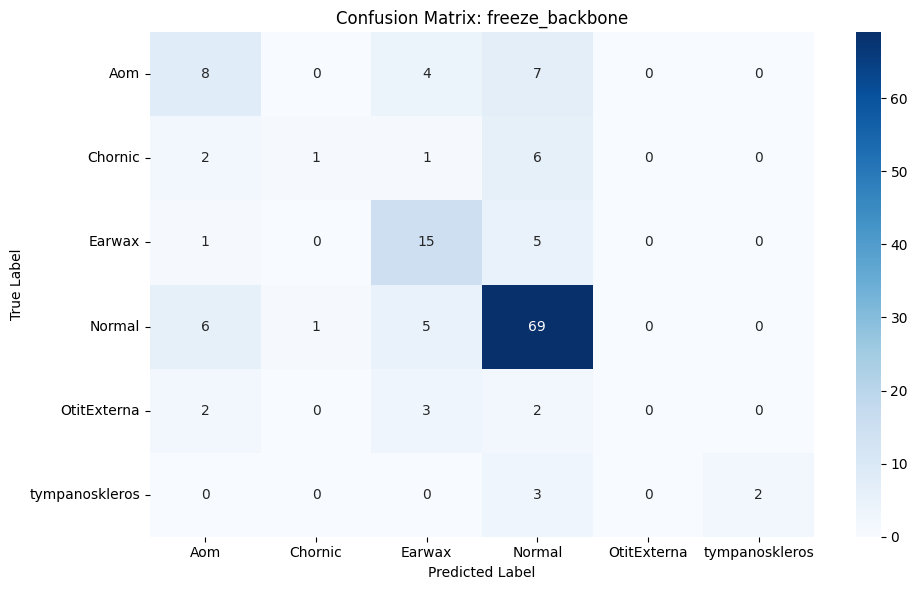


Evaluating strategy: last1+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/bd0080e9981840b0bffa3987641c2545/checkpoints/last1+head-best-f1-epoch=02-val_f1=0.4280.ckpt

Accuracy:  0.6923
Precision: 0.8339
Recall:    0.4509
F1 Score:  0.4649

Classification Report:
                precision    recall  f1-score   support

           Aom       1.00      0.21      0.35        19
       Chornic       0.75      0.30      0.43        10
        Earwax       0.41      1.00      0.58        21
        Normal       0.84      0.85      0.85        81
   OtitExterna       1.00      0.14      0.25         7
tympanoskleros       1.00      0.20      0.33         5

      accuracy                           0.69       143
     macro avg       0.83      0.45      0.46       143
  weighted avg       0.81      0.69      0.67       143



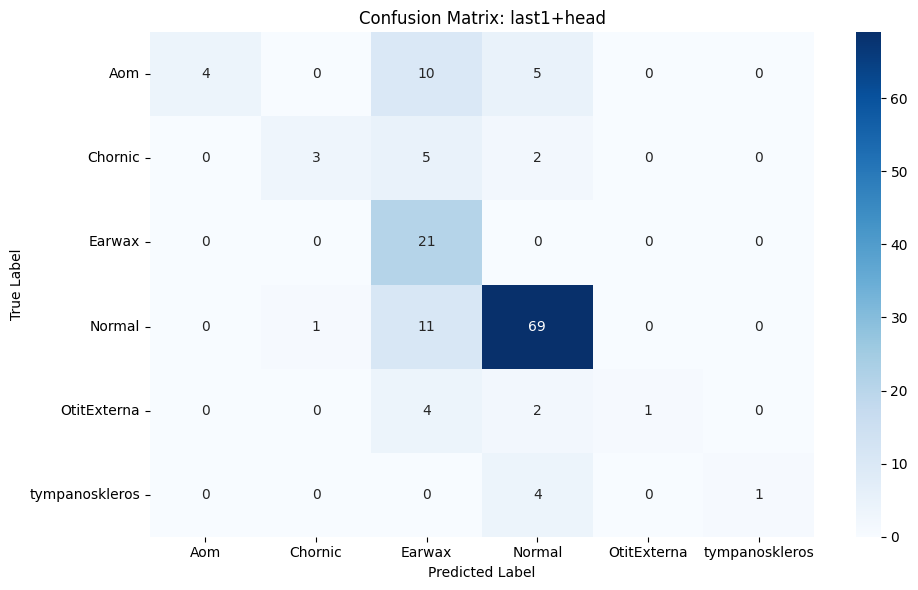


Evaluating strategy: last2+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/46788dc38ee449f78f61e3e1e8b7b312/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt

Accuracy:  0.7552
Precision: 0.6801
Recall:    0.5613
F1 Score:  0.5875

Classification Report:
                precision    recall  f1-score   support

           Aom       0.70      0.37      0.48        19
       Chornic       1.00      0.40      0.57        10
        Earwax       0.69      0.86      0.77        21
        Normal       0.81      0.91      0.86        81
   OtitExterna       0.38      0.43      0.40         7
tympanoskleros       0.50      0.40      0.44         5

      accuracy                           0.76       143
     macro avg       0.68      0.56      0.59       143
  weighted avg       0.76      0.76      0.74       143



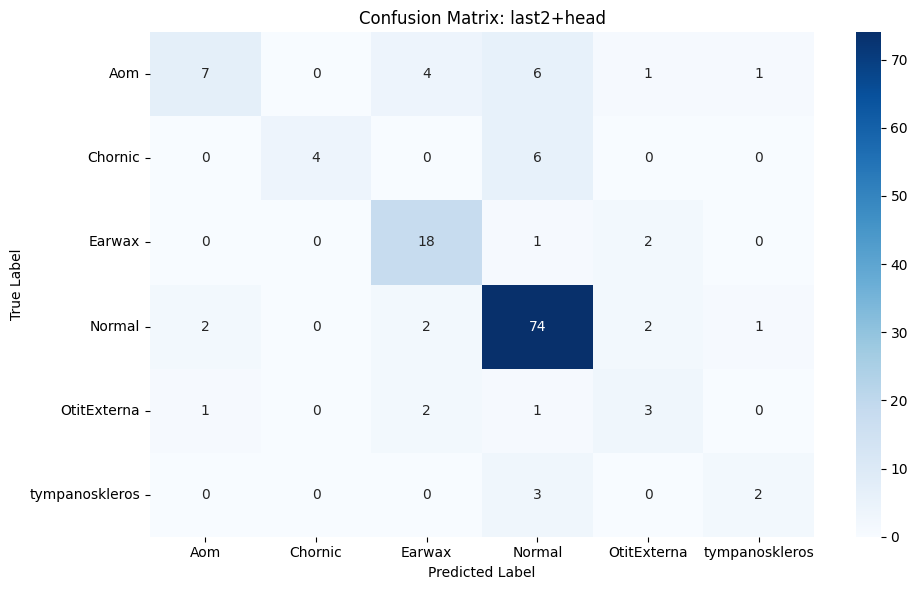


Evaluating strategy: last3+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/2bf11cbd630446cc8c50473e638aa050/checkpoints/last3+head-best-f1-epoch=05-val_f1=0.0654.ckpt

Accuracy:  0.1538
Precision: 0.1664
Recall:    0.1870
F1 Score:  0.1432

Classification Report:
                precision    recall  f1-score   support

           Aom       0.12      0.16      0.14        19
       Chornic       0.11      0.20      0.14        10
        Earwax       0.27      0.14      0.19        21
        Normal       0.37      0.14      0.20        81
   OtitExterna       0.04      0.29      0.07         7
tympanoskleros       0.09      0.20      0.12         5

      accuracy                           0.15       143
     macro avg       0.17      0.19      0.14       143
  weighted avg       0.28      0.15      0.18       143



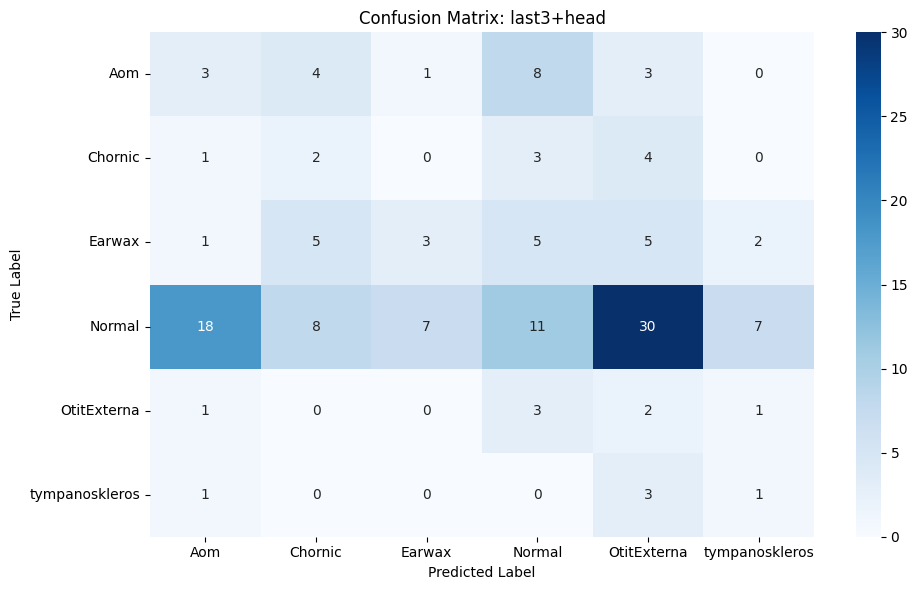


Evaluating strategy: last4+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/d2cbb533f7ea48f49a169ba878f48f7d/checkpoints/last4+head-best-f1-epoch=02-val_f1=0.4643.ckpt

Accuracy:  0.7483
Precision: 0.6937
Recall:    0.5509
F1 Score:  0.5784

Classification Report:
                precision    recall  f1-score   support

           Aom       0.82      0.47      0.60        19
       Chornic       0.33      0.40      0.36        10
        Earwax       0.69      0.86      0.77        21
        Normal       0.82      0.89      0.85        81
   OtitExterna       1.00      0.29      0.44         7
tympanoskleros       0.50      0.40      0.44         5

      accuracy                           0.75       143
     macro avg       0.69      0.55      0.58       143
  weighted avg       0.76      0.75      0.74       143



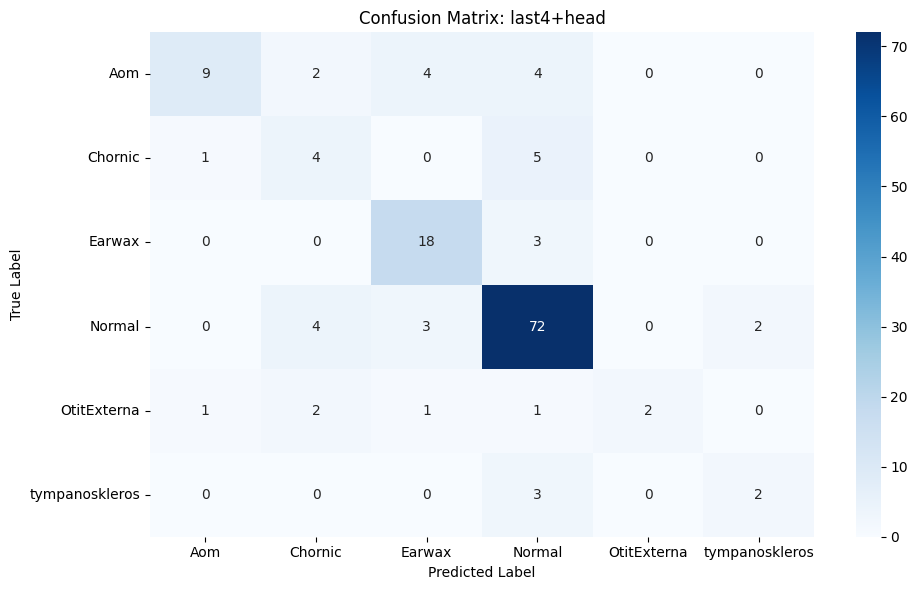


Evaluating strategy: full
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e222739db27848ba8e4b7a1368fa87a7/checkpoints/full-best-f1-epoch=00-val_f1=0.4171.ckpt

Accuracy:  0.6503
Precision: 0.4396
Recall:    0.3466
F1 Score:  0.3309

Classification Report:
                precision    recall  f1-score   support

           Aom       0.38      0.26      0.31        19
       Chornic       0.00      0.00      0.00        10
        Earwax       0.50      0.81      0.62        21
        Normal       0.75      0.86      0.80        81
   OtitExterna       1.00      0.14      0.25         7
tympanoskleros       0.00      0.00      0.00         5

      accuracy                           0.65       143
     macro avg       0.44      0.35      0.33       143
  weighted avg       0.60      0.65      0.60       143



/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/py

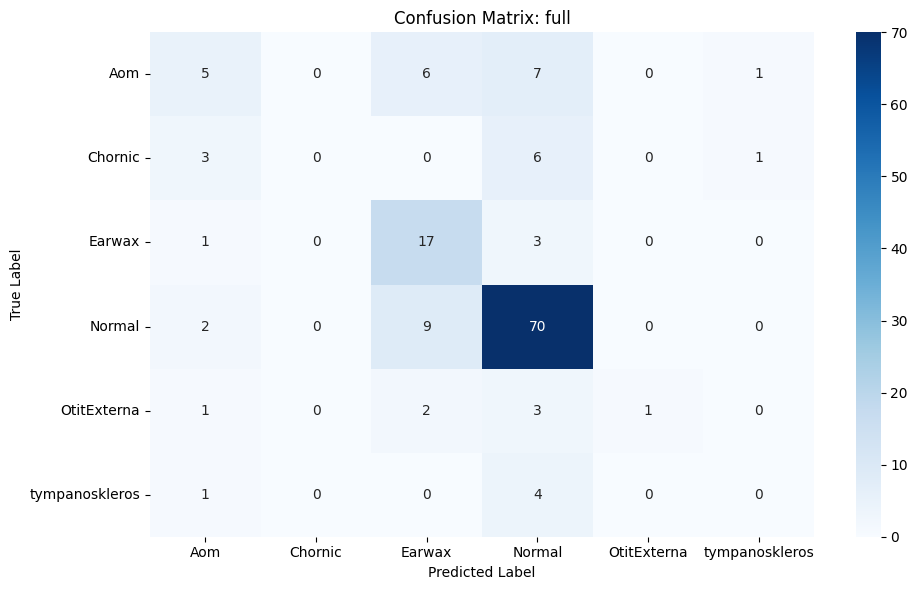

In [9]:
seed_everything(42, workers=True)

# Set MLflow tracking
tracking_uri = "file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("eardrum_finetune_strategies")

def evaluate_model(strategy, ckpt_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"\nEvaluating strategy: {strategy}")
    print("Using device:", device)
    print("Loaded checkpoint:", ckpt_path)

    # Load model
    model = EfficientNetV2Lightning.load_from_checkpoint(ckpt_path)
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:")
    report_txt = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    print(report_txt)

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {strategy}")
    plt.tight_layout()
    plt.show()

    # MLflow logging
    with mlflow.start_run(run_name=f"eval_{strategy}", nested=True):
        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1", f1)

        # Save and log classification report
        report_path = f"classification_report_{strategy}.txt"
        with open(report_path, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(report_path)

        # Also log the checkpoint used
        mlflow.log_artifact(ckpt_path)

# === Load latest checkpoint file ===
import glob
import os
import json

checkpoint_files = glob.glob("best_checkpoints_*.json")
if not checkpoint_files:
    raise FileNotFoundError("No best_checkpoints_*.json files found.")

latest_ckpt_file = max(checkpoint_files, key=os.path.getmtime)
print(f"\nLoading latest checkpoint file: {latest_ckpt_file}")

with open(latest_ckpt_file, "r") as f:
    best_ckpt_paths = json.load(f)

# === Evaluate all saved strategies ===
for strategy, ckpt_path in best_ckpt_paths.items():
    evaluate_model(strategy, ckpt_path)

## 12. Fine-Tuning Strategy Evaluation Summary (After Learning Rate Tuning)

| Strategy           | Accuracy | Precision | Recall  | F1 Score |
|-------------------|----------|-----------|---------|----------|
| `freeze_backbone` | 0.6643   | 0.5345    | 0.4145  | 0.4282   |
| `last1+head`      | 0.6923   | **0.8339**| 0.4509  | 0.4649   |
| `last2+head`      | **0.7552** | 0.6801    | **0.5613**  | **0.5875**   |
| `last3+head`      | 0.1538   | 0.1664    | 0.1870  | 0.1432   |
| `last4+head`      | 0.7483   | 0.6937    | 0.5509  | 0.5784   |
| `full`            | 0.6503   | 0.4396    | 0.3466  | 0.3309   |

**Best Strategy: `last2+head`**

- After applying **automatic learning rate tuning**, the strategy `last2+head` achieved the **highest F1 Score (0.5875)** and **highest Recall (0.5613)**, outperforming all other strategies.
- It also maintained strong **Precision (0.6801)** and the **best Accuracy (0.7552)**.
- This indicates `last2+head` is the most balanced and reliable strategy for medical image classification in our case, optimizing detection performance without overfitting.
- In contrast, the previously best-performing strategy `last3+head` drastically underperformed (F1 = 0.1432) post-tuning, possibly due to sensitivity to learning rate or overfitting.

*Checkpoint file evaluated: `last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt` (Seed = 42)*

## 13. Model Evaluation (F1 Score) for each Class on Test Dataset

Seed set to 42



Loading latest checkpoint file: best_checkpoints_20250716-132912.json

Evaluating strategy: freeze_backbone
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e88c8d6261114446830bdc004dc33cfb/checkpoints/freeze_backbone-best-f1-epoch=03-val_f1=0.4388.ckpt

Accuracy:  0.6643
Precision: 0.5345
Recall:    0.4145
F1 Score (macro):  0.4282

F1 Score per class:
  Aom: 0.4211
  Chornic: 0.1667
  Earwax: 0.6122
  Normal: 0.7977
  OtitExterna: 0.0000
  tympanoskleros: 0.5714

Classification Report:
                precision    recall  f1-score   support

           Aom       0.42      0.42      0.42        19
       Chornic       0.50      0.10      0.17        10
        Earwax       0.54      0.71      0.61        21
        Normal       0.75      0.85      0.80        81
   OtitExterna       0.00      0.00      0.00         7
tympanoskleros       1.00      0.40      0.57         5

      accuracy                 

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/py

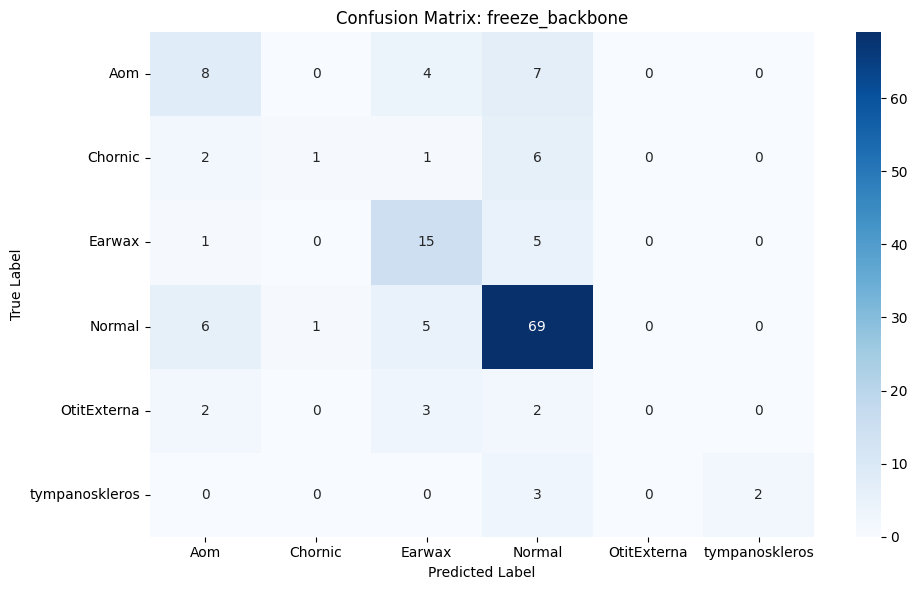


Evaluating strategy: last1+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/bd0080e9981840b0bffa3987641c2545/checkpoints/last1+head-best-f1-epoch=02-val_f1=0.4280.ckpt

Accuracy:  0.6923
Precision: 0.8339
Recall:    0.4509
F1 Score (macro):  0.4649

F1 Score per class:
  Aom: 0.3478
  Chornic: 0.4286
  Earwax: 0.5833
  Normal: 0.8466
  OtitExterna: 0.2500
  tympanoskleros: 0.3333

Classification Report:
                precision    recall  f1-score   support

           Aom       1.00      0.21      0.35        19
       Chornic       0.75      0.30      0.43        10
        Earwax       0.41      1.00      0.58        21
        Normal       0.84      0.85      0.85        81
   OtitExterna       1.00      0.14      0.25         7
tympanoskleros       1.00      0.20      0.33         5

      accuracy                           0.69       143
     macro avg       0.83      0.45      0.46       143


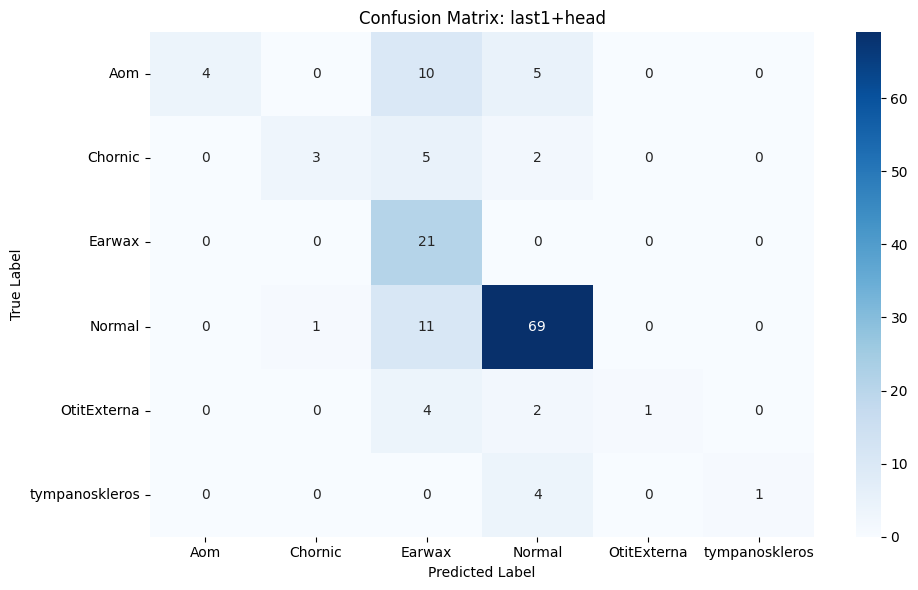


Evaluating strategy: last2+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/46788dc38ee449f78f61e3e1e8b7b312/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt

Accuracy:  0.7552
Precision: 0.6801
Recall:    0.5613
F1 Score (macro):  0.5875

F1 Score per class:
  Aom: 0.4828
  Chornic: 0.5714
  Earwax: 0.7660
  Normal: 0.8605
  OtitExterna: 0.4000
  tympanoskleros: 0.4444

Classification Report:
                precision    recall  f1-score   support

           Aom       0.70      0.37      0.48        19
       Chornic       1.00      0.40      0.57        10
        Earwax       0.69      0.86      0.77        21
        Normal       0.81      0.91      0.86        81
   OtitExterna       0.38      0.43      0.40         7
tympanoskleros       0.50      0.40      0.44         5

      accuracy                           0.76       143
     macro avg       0.68      0.56      0.59       143


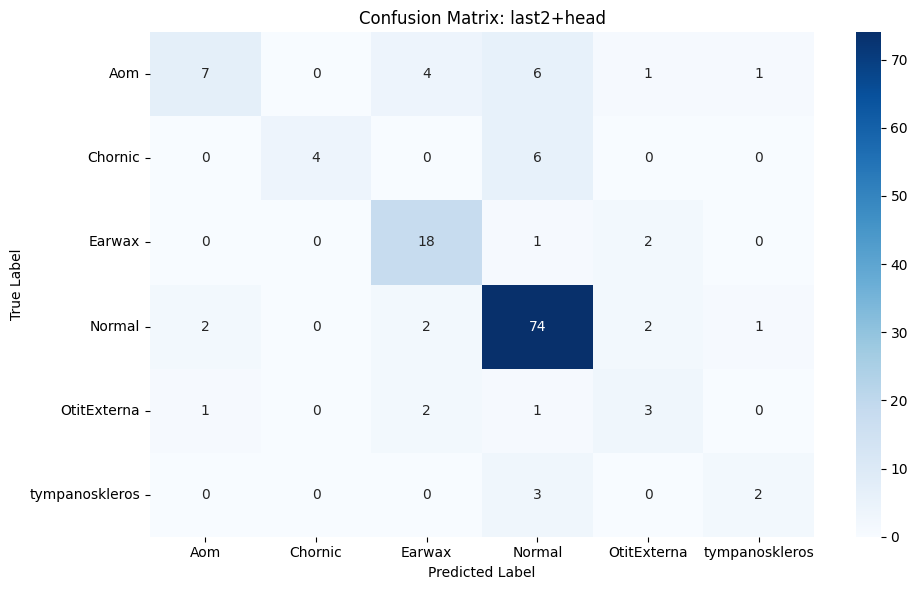


Evaluating strategy: last3+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/2bf11cbd630446cc8c50473e638aa050/checkpoints/last3+head-best-f1-epoch=05-val_f1=0.0654.ckpt

Accuracy:  0.1538
Precision: 0.1664
Recall:    0.1870
F1 Score (macro):  0.1432

F1 Score per class:
  Aom: 0.1364
  Chornic: 0.1379
  Earwax: 0.1875
  Normal: 0.1982
  OtitExterna: 0.0741
  tympanoskleros: 0.1250

Classification Report:
                precision    recall  f1-score   support

           Aom       0.12      0.16      0.14        19
       Chornic       0.11      0.20      0.14        10
        Earwax       0.27      0.14      0.19        21
        Normal       0.37      0.14      0.20        81
   OtitExterna       0.04      0.29      0.07         7
tympanoskleros       0.09      0.20      0.12         5

      accuracy                           0.15       143
     macro avg       0.17      0.19      0.14       143


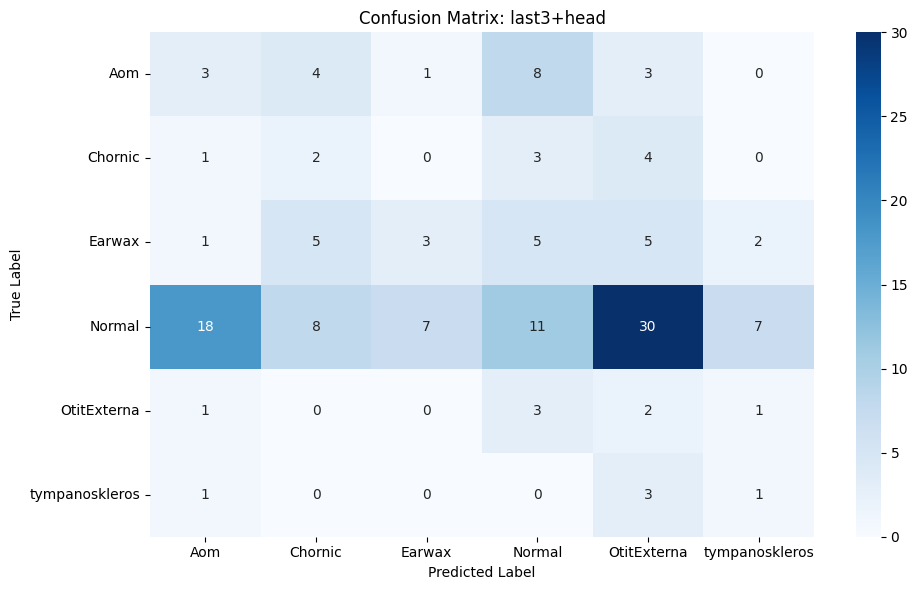


Evaluating strategy: last4+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/d2cbb533f7ea48f49a169ba878f48f7d/checkpoints/last4+head-best-f1-epoch=02-val_f1=0.4643.ckpt

Accuracy:  0.7483
Precision: 0.6937
Recall:    0.5509
F1 Score (macro):  0.5784

F1 Score per class:
  Aom: 0.6000
  Chornic: 0.3636
  Earwax: 0.7660
  Normal: 0.8521
  OtitExterna: 0.4444
  tympanoskleros: 0.4444

Classification Report:
                precision    recall  f1-score   support

           Aom       0.82      0.47      0.60        19
       Chornic       0.33      0.40      0.36        10
        Earwax       0.69      0.86      0.77        21
        Normal       0.82      0.89      0.85        81
   OtitExterna       1.00      0.29      0.44         7
tympanoskleros       0.50      0.40      0.44         5

      accuracy                           0.75       143
     macro avg       0.69      0.55      0.58       143


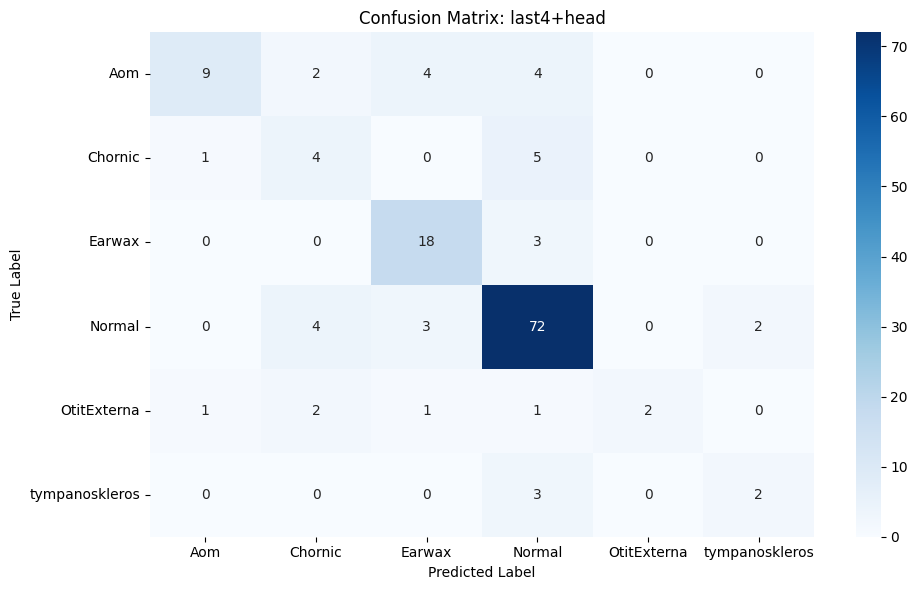


Evaluating strategy: full
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/e222739db27848ba8e4b7a1368fa87a7/checkpoints/full-best-f1-epoch=00-val_f1=0.4171.ckpt

Accuracy:  0.6503
Precision: 0.4396
Recall:    0.3466
F1 Score (macro):  0.3309

F1 Score per class:
  Aom: 0.3125
  Chornic: 0.0000
  Earwax: 0.6182
  Normal: 0.8046
  OtitExterna: 0.2500
  tympanoskleros: 0.0000

Classification Report:
                precision    recall  f1-score   support

           Aom       0.38      0.26      0.31        19
       Chornic       0.00      0.00      0.00        10
        Earwax       0.50      0.81      0.62        21
        Normal       0.75      0.86      0.80        81
   OtitExterna       1.00      0.14      0.25         7
tympanoskleros       0.00      0.00      0.00         5

      accuracy                           0.65       143
     macro avg       0.44      0.35      0.33       143
  weighted a

/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/lib/py

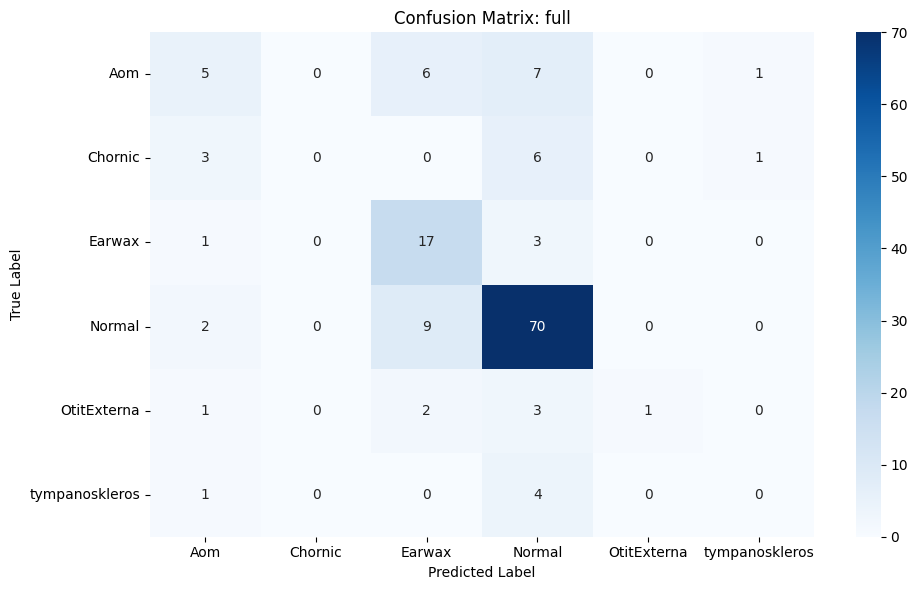

In [23]:
seed_everything(42, workers=True)

# Set MLflow tracking
tracking_uri = "file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("eardrum_finetune_strategies")

def evaluate_model(strategy, ckpt_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"\nEvaluating strategy: {strategy}")
    print("Using device:", device)
    print("Loaded checkpoint:", ckpt_path)

    # Load model
    model = EfficientNetV2Lightning.load_from_checkpoint(ckpt_path)
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score (macro):  {f1_macro:.4f}")

    print("\nF1 Score per class:")
    for idx, score in enumerate(f1_per_class):
        print(f"  {test_dataset.classes[idx]}: {score:.4f}")

    print("\nClassification Report:")
    report_txt = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    print(report_txt)

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {strategy}")
    plt.tight_layout()
    plt.show()

    # MLflow logging
    with mlflow.start_run(run_name=f"eval_{strategy}", nested=True):
        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1_macro", f1_macro)

        # Log F1 scores per class
        for idx, score in enumerate(f1_per_class):
            class_metric_name = f"class_{test_dataset.classes[idx]}_f1"
            mlflow.log_metric(class_metric_name, score)

        # Save and log classification report
        report_path = f"classification_report_{strategy}.txt"
        with open(report_path, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(report_path)

        # Also log the checkpoint used
        mlflow.log_artifact(ckpt_path)

# === Load latest checkpoint file ===
import glob
import os
import json

checkpoint_files = glob.glob("best_checkpoints_*.json")
if not checkpoint_files:
    raise FileNotFoundError("No best_checkpoints_*.json files found.")

latest_ckpt_file = max(checkpoint_files, key=os.path.getmtime)
print(f"\nLoading latest checkpoint file: {latest_ckpt_file}")

with open(latest_ckpt_file, "r") as f:
    best_ckpt_paths = json.load(f)

# === Evaluate all saved strategies ===
for strategy, ckpt_path in best_ckpt_paths.items():
    evaluate_model(strategy, ckpt_path)

## 14. F1 Score for Individual Class Analysis and Conclusions

Per-Class F1 Score Across Fine-Tuning Strategies

| Class           | freeze   | last1+head | last2+head | last3+head | last4+head | full    | Notes         |
|-----------------|----------|------------|------------|------------|------------|---------|---------------|
| Aom             | 0.4211   | 0.3478     | 0.4828     | 0.1364     | 0.6000     | 0.3125  | Acceptable     |
| Chornic         | 0.1667   | 0.4286     | 0.5714     | 0.1379     | 0.3636     | 0.0000  | Unstable       |
| Earwax          | 0.6122   | 0.5833     | 0.7660     | 0.1875     | 0.7660     | 0.6182  | Strong         |
| Normal          | 0.7977   | 0.8466     | 0.8605     | 0.1982     | 0.8521     | 0.8046  | Strong         |
| OtitExterna     | 0.0000   | 0.2500     | 0.4000     | 0.0741     | 0.4444     | 0.2500  | Weak           |
| tympanoskleros  | 0.5714   | 0.3333     | 0.4444     | 0.1250     | 0.4444     | 0.0000  | Very unstable  |

---

Sample Distribution Summary

Original Class Distribution (Before Exclusion)
| Class               | Total Images |
|---------------------|--------------|
| Normal              | 534          |
| Earwax              | 140          |
| AOM                 | 119          |
| Chornic             | 63           |
| OtitExterna         | 41           |
| Tympanosclerosis    | 28           |
| Ear Ventilation     | 16 (excluded)|
| Pseudo Membranes    | 11 (excluded)|
| Foreign Bodies      | 3 (excluded) |

Image Count After Train/Val/Test Split

| Class            | Train | Val | Test | Total |
|------------------|-------|-----|------|-------|
| Normal           | 373   | 80  | 81   | 534   |
| Earwax           | 98    | 21  | 21   | 140   |
| AOM              | 83    | 17  | 19   | 119   |
| Chornic          | 44    | 9   | 10   | 63    |
| OtitExterna      | 28    | 6   | 7    | 41    |
| Tympanosclerosis | 19    | 4   | 5    | 28    |

---

Problem

Despite being present in the dataset after initial cleaning, some classes:
- Have fewer than 30 total images,
- Include fewer than 10 images in the test set,
- And consistently produce poor F1 scores.

These classes introduce noise and instability into training and evaluation.

---

Classes to Exclude

| Class Name        | Reason                                  |
|-------------------|------------------------------------------|
| Tympanosclerosis  | Only 28 total images (5 in test); F1 = 0.0 in `full` strategy; unstable across others |
| Otitis Externa    | Only 41 total images (7 in test); F1 < 0.45 in all strategies; often ignored by model |

---

Final Recommendation

- **Exclude**: `tympanoskleros` (Tympanosclerosis)
- **Optionally exclude**: `OtitExterna` (Otitis Externa) if not medically critical

This adjustment should improve:
- Overall macro F1
- Training stability
- Generalization to real-world clinical data

---

## 15. Cycle 2: Dataset Setup with 5 Excluded Classes

Removing old extracted dataset...
Removing old split dataset...
Found existing zip file. Skipping download.
Unzipping dataset...
Dataset extracted to /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/eardrum_dataset

Original class distribution (before exclusion):
  OtitExterna: 41 images
  tympanoskleros: 28 images
  Aom: 119 images
  Earventulation: 16 images
  Earwax: 140 images
  PseduoMembran: 11 images
  Normal: 534 images
  Foreign: 3 images
  Chornic: 63 images

Dataset organized and split into train/val/test folders.
Excluded classes: 'Foreign', 'PseduoMembran', 'Earventulation', 'tympanoskleros', 'OtitExterna'

Image count per class (after split):

Split: train
  Aom: 83 images
  Earwax: 98 images
  Normal: 373 images
  Chornic: 44 images

Split: val
  Aom: 17 images
  Earwax: 21 images
  Normal: 80 images
  Chornic: 9 images

Split: test
  Aom: 19 images
  Earwax: 21 images
  Normal: 81 images
  Chornic: 10 images

Showing 5 images per class from 'train':

Cla

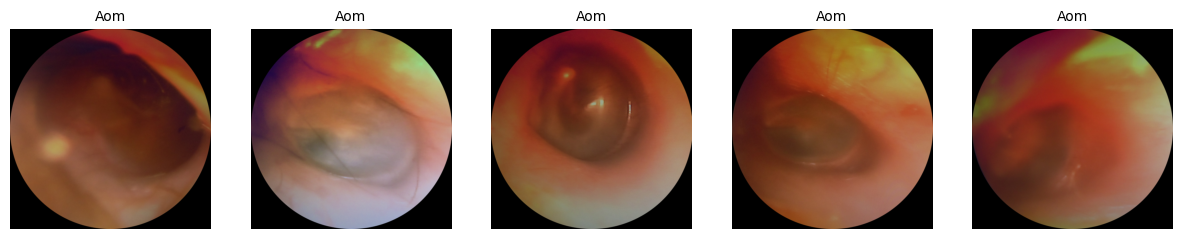


Class: Earwax


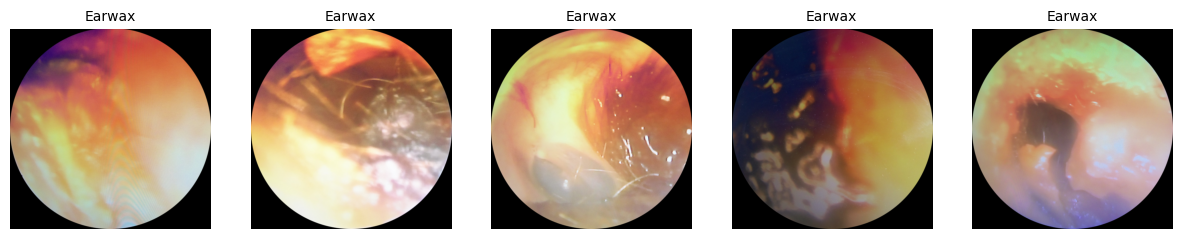


Class: Normal


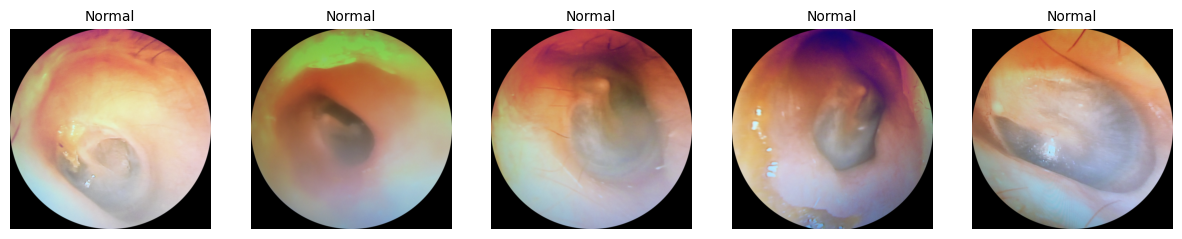


Class: Chornic


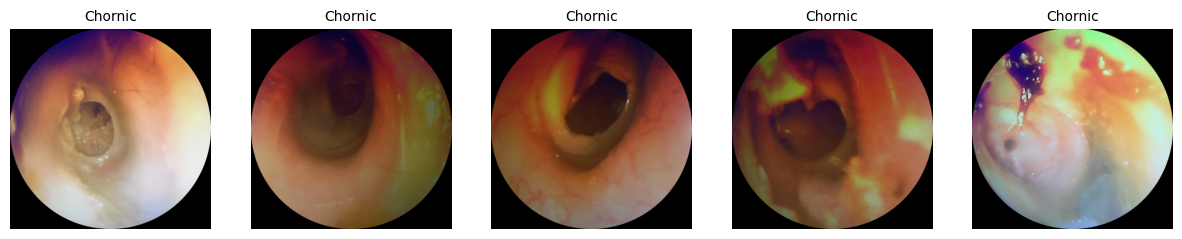

In [24]:
# ------------------- Block 0: Download & Unpack Dataset -------------------
def download_and_unpack_kaggle_dataset():
    kaggle_dataset = "erdalbasaran/eardrum-dataset-otitis-media"
    zip_file = Path("eardrum-dataset-otitis-media.zip")
    extract_dir = Path("eardrum_dataset")

    # Clean up old data
    if extract_dir.exists():
        print("Removing old extracted dataset...")
        shutil.rmtree(extract_dir)

    if Path("eardrum_split").exists():
        print("Removing old split dataset...")
        shutil.rmtree("eardrum_split")

    # Download if not present
    if not zip_file.exists():
        print("Downloading dataset from Kaggle...")
        os.system(f'kaggle datasets download -d {kaggle_dataset}')
    else:
        print("Found existing zip file. Skipping download.")

    # Unzip
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted to {extract_dir.resolve()}")

download_and_unpack_kaggle_dataset()

# ------------------- Block 1: Setup -------------------
random.seed(42)

src_dir = Path("eardrum_dataset/eardrumDs")  # Extracted dataset directory
base_dir = Path('eardrum_split')             # Output for train/val/test split
splits = ['train', 'val', 'test']
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

print("\nOriginal class distribution (before exclusion):")
all_classes = [d for d in src_dir.iterdir() if d.is_dir()]
for cls_dir in all_classes:
    count = len(list(cls_dir.glob("*")))
    print(f"  {cls_dir.name}: {count} images")

# Updated exclusion list based on F1 analysis and class size
excluded_classes = {
    'Foreign',            # 3 samples
    'PseduoMembran',      # 11 samples
    'Earventulation',     # 16 samples
    'tympanoskleros',     # 28 samples, unstable F1
    'OtitExterna'         # 41 samples, weak F1
}

# Filter class list
classes = [d.name for d in src_dir.iterdir() if d.is_dir() and d.name not in excluded_classes]

# Create split folders
for split in splits:
    for cls in classes:
        os.makedirs(base_dir / split / cls, exist_ok=True)

# ------------------- Block 2: Split the dataset -------------------
for cls in classes:
    images = list((src_dir / cls).glob('*'))
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_files = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split, files in split_files.items():
        for img in files:
            dest = base_dir / split / cls / img.name
            shutil.copy(img, dest)

print("\nDataset organized and split into train/val/test folders.")
print("Excluded classes: 'Foreign', 'PseduoMembran', 'Earventulation', 'tympanoskleros', 'OtitExterna'\n")

# ------------------- Block 3: Display image counts after split -------------------
print("Image count per class (after split):")
for split in splits:
    print(f"\nSplit: {split}")
    for cls in classes:
        class_path = base_dir / split / cls
        count = len(list(class_path.glob('*')))
        print(f"  {cls}: {count} images")

# ------------------- Block 4: Show sample images -------------------
def show_images_per_class(split="train", num_images=5):
    print(f"\nShowing {num_images} images per class from '{split}':")
    class_dirs = list((base_dir / split).glob('*'))
    for cls_dir in class_dirs:
        image_paths = list(cls_dir.glob("*"))
        if not image_paths:
            continue
        selected_images = random.sample(image_paths, min(num_images, len(image_paths)))
        print(f"\nClass: {cls_dir.name}")
        plt.figure(figsize=(15, 3))
        for i, img_path in enumerate(selected_images):
            img = Image.open(img_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls_dir.name, fontsize=10)
        plt.show()

# Show training samples
show_images_per_class("train")

## 16. Cycle 2: Training Multiple Fine-Tuning Strategies with LR Tuning

In [19]:
seed_everything(42, workers=True)

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_dataloaders()

def set_finetune_strategy(model, strategy):
    if strategy == "freeze_backbone":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last1+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-1].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last2+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-2:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last3+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-3:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "last4+head":
        for param in model.model.parameters():
            param.requires_grad = False
        for param in model.model.blocks[-4:].parameters():
            param.requires_grad = True
        for param in model.model.get_classifier().parameters():
            param.requires_grad = True
    elif strategy == "full":
        for param in model.model.parameters():
            param.requires_grad = True

if __name__ == "__main__":
    strategies = [
        "freeze_backbone", "last1+head", "last2+head",
        "last3+head", "last4+head", "full"
    ]

    num_classes = len(train_dataset.classes)
    best_ckpt_paths = {}

    for strategy in strategies:
        print(f"\nTraining strategy: {strategy}")
        model = EfficientNetV2Lightning(num_classes=num_classes)
        set_finetune_strategy(model, strategy)

        # MLflow Logger
        mlflow_logger = MLFlowLogger(
            experiment_name="eardrum_finetune_strategies",
            tracking_uri="file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns",
            run_name=strategy
        )

        # Callbacks
        early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
        checkpoint = ModelCheckpoint(
            monitor="val_f1",
            mode="max",
            save_top_k=1,
            filename=f"{strategy}-best-f1-{{epoch:02d}}-{{val_f1:.4f}}"
        )

        # Precision based on device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        precision = "16-mixed" if device == "cuda" else 32

        # Trainer
        trainer = pl.Trainer(
            max_epochs=20,
            accelerator="auto",
            precision=precision,
            callbacks=[early_stop, checkpoint],
            logger=mlflow_logger
        )

        # === Find best learning rate ===
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        new_lr = lr_finder.suggestion()
        print(f"Suggested learning rate: {new_lr:.2e}")
        model.hparams.lr = new_lr

        # Train the model
        trainer.fit(model, train_loader, val_loader)

        # Save best checkpoint path
        ckpt_path = checkpoint.best_model_path
        print(f"Best checkpoint for '{strategy}' saved at: {ckpt_path}")
        best_ckpt_paths[strategy] = ckpt_path

        # Log checkpoint and model
        mlflow_logger.experiment.log_artifact(mlflow_logger.run_id, ckpt_path)
        example_input = torch.randn(1, 3, 224, 224).numpy()
        with mlflow.start_run(run_id=mlflow_logger.run_id):
            mlflow.pytorch.log_model(
                model,
                artifact_path="model",
                input_example=example_input
            )

    # Save best checkpoint paths to JSON
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    json_path = f"best_checkpoints_{timestamp}.json"
    with open(json_path, "w") as f:
        json.dump(best_ckpt_paths, f)
    print(f"Saved best checkpoint paths to {json_path}")

Seed set to 42



Training strategy: freeze_backbone


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_e52017d5-7df1-4227-8cd5-78c388124d93.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_e52017d5-7df1-4227-8cd5-78c388124d93.ckpt

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
7.7 K     Trainable params
20.2 M    Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Suggested learning rate: 4.37e-02


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

2025/07/30 15:44:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'freeze_backbone' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/504e26583dbc4fd2a02afa62486ba771/checkpoints/freeze_backbone-best-f1-epoch=03-val_f1=0.4388.ckpt

Training strategy: last1+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_2e4069c0-6a7b-4b4e-acf3-31e1baf248a7.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_2e4069c0-6a7b-4b4e-acf3-31e1baf248a7.ckpt


Suggested learning rate: 1.32e-03



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
14.6 M    Trainable params
5.6 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

2025/07/30 15:52:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last1+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/07d6b0fe798d4be2b5dd180fc25cfacd/checkpoints/last1+head-best-f1-epoch=02-val_f1=0.4280.ckpt

Training strategy: last2+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0003019951720402019
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_e1478d04-b594-4053-98b4-e6f51cba693a.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_e1478d04-b594-4053-98b4-e6f51cba693a.ckpt


Suggested learning rate: 3.02e-04



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
18.0 M    Trainable params
2.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

2025/07/30 16:01:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last2+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f68679354863456192ac88b92eaf1e44/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt

Training strategy: last3+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 4.786300923226383e-07
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_213ae199-8bd3-4f52-9df3-fe535482cc62.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_213ae199-8bd3-4f52-9df3-fe535482cc62.ckpt


Suggested learning rate: 4.79e-07



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.0 M    Trainable params
1.2 M     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

2025/07/30 16:14:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last3+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/45604617e9614d3297ae658732b27ee5/checkpoints/last3+head-best-f1-epoch=05-val_f1=0.0654.ckpt

Training strategy: last4+head


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0004365158322401656
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_974de0c9-ff6d-41d7-b171-3515c6f9dcf9.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_974de0c9-ff6d-41d7-b171-3515c6f9dcf9.ckpt


Suggested learning rate: 4.37e-04



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
19.5 M    Trainable params
644 K     Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

2025/07/30 16:22:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'last4+head' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/b4081fe9af994c2d913c065eb1987faa/checkpoints/last4+head-best-f1-epoch=02-val_f1=0.4643.ckpt

Training strategy: full


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0010964781961431851
Restoring states from the checkpoint path at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_b687206c-0f50-4eb9-bc33-e8d81b87afbb.ckpt
Restored all states from the checkpoint at /Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/.lr_find_b687206c-0f50-4eb9-bc33-e8d81b87afbb.ckpt


Suggested learning rate: 1.10e-03



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EfficientNet      | 20.2 M | train
1 | loss_fn | CrossEntropyLoss  | 0      | train
2 | val_f1  | MulticlassF1Score | 0      | train
3 | test_f1 | MulticlassF1Score | 0      | train
------------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.741    Total estimated model params size (MB)
733       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                         | 0…

Training: |                                                                                                | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

Validation: |                                                                                              | 0…

2025/07/30 16:33:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best checkpoint for 'full' saved at: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/d94b6a98ea0e40529a9e7ba22adc1d3b/checkpoints/full-best-f1-epoch=00-val_f1=0.4171.ckpt
Saved best checkpoint paths to best_checkpoints_20250730-163348.json


## 17. Cycle 2: Model Evaluation

Seed set to 42



Loaded test dataset with 4 classes: ['Aom', 'Chornic', 'Earwax', 'Normal']

Loading latest checkpoint file: best_checkpoints_20250730-163348.json

Evaluating strategy: freeze_backbone
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/504e26583dbc4fd2a02afa62486ba771/checkpoints/freeze_backbone-best-f1-epoch=03-val_f1=0.4388.ckpt

Accuracy:  0.8015
Precision: 0.8084
Recall:    0.6850
F1 Score (macro):  0.7134

F1 Score per class:
  Aom: 0.6829
  Chornic: 0.5714
  Earwax: 0.7317
  Normal: 0.8675

Classification Report:
              precision    recall  f1-score   support

         Aom       0.64      0.74      0.68        19
     Chornic       1.00      0.40      0.57        10
      Earwax       0.75      0.71      0.73        21
      Normal       0.85      0.89      0.87        81

    accuracy                           0.80       131
   macro avg       0.81      0.69      0.71       131
weighted avg    

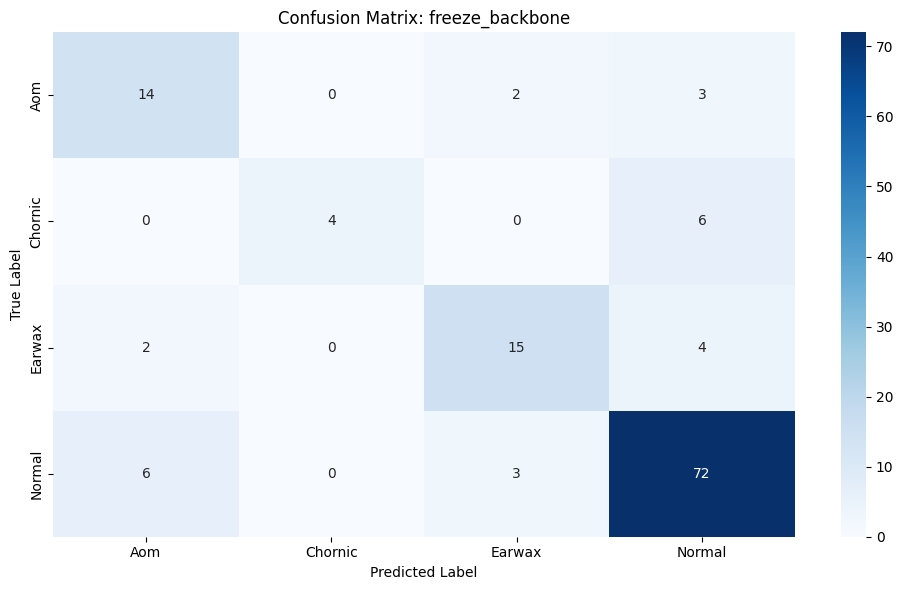


Evaluating strategy: last1+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/07d6b0fe798d4be2b5dd180fc25cfacd/checkpoints/last1+head-best-f1-epoch=02-val_f1=0.4280.ckpt

Accuracy:  0.8244
Precision: 0.8427
Recall:    0.8177
F1 Score (macro):  0.8000

F1 Score per class:
  Aom: 0.7333
  Chornic: 0.9000
  Earwax: 0.6780
  Normal: 0.8889

Classification Report:
              precision    recall  f1-score   support

         Aom       1.00      0.58      0.73        19
     Chornic       0.90      0.90      0.90        10
      Earwax       0.53      0.95      0.68        21
      Normal       0.94      0.84      0.89        81

    accuracy                           0.82       131
   macro avg       0.84      0.82      0.80       131
weighted avg       0.88      0.82      0.83       131



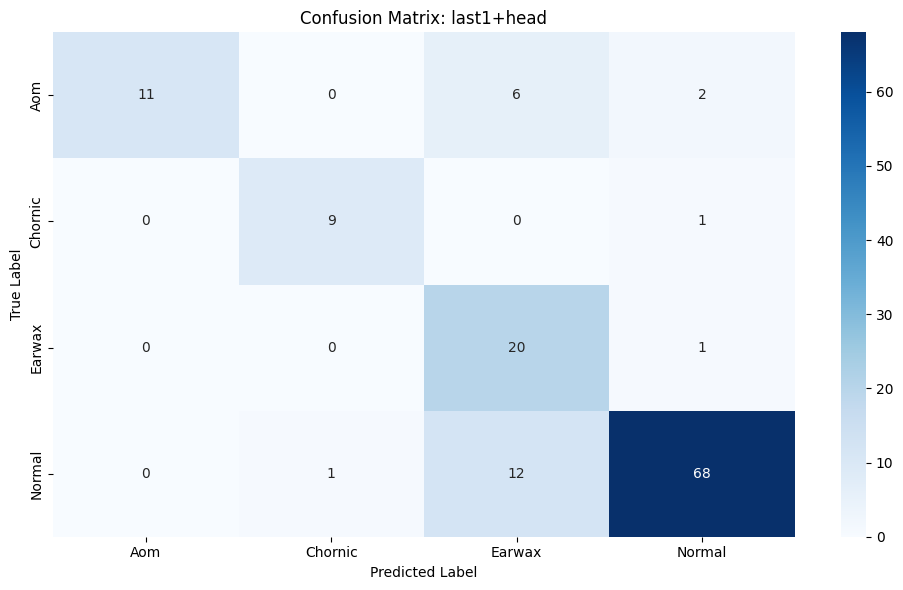


Evaluating strategy: last2+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/f68679354863456192ac88b92eaf1e44/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt

Accuracy:  0.9084
Precision: 0.7153
Recall:    0.6890
F1 Score (macro):  0.6993

F1 Score per class:
  Aom: 0.8824
  Chornic: 0.8000
  Earwax: 0.8636
  Normal: 0.9506

Classification Report:
              precision    recall  f1-score   support

         Aom       1.00      0.79      0.88        19
     Chornic       0.80      0.80      0.80        10
      Earwax       0.83      0.90      0.86        21
      Normal       0.95      0.95      0.95        81

   micro avg       0.92      0.91      0.92       131
   macro avg       0.89      0.86      0.87       131
weighted avg       0.93      0.91      0.92       131



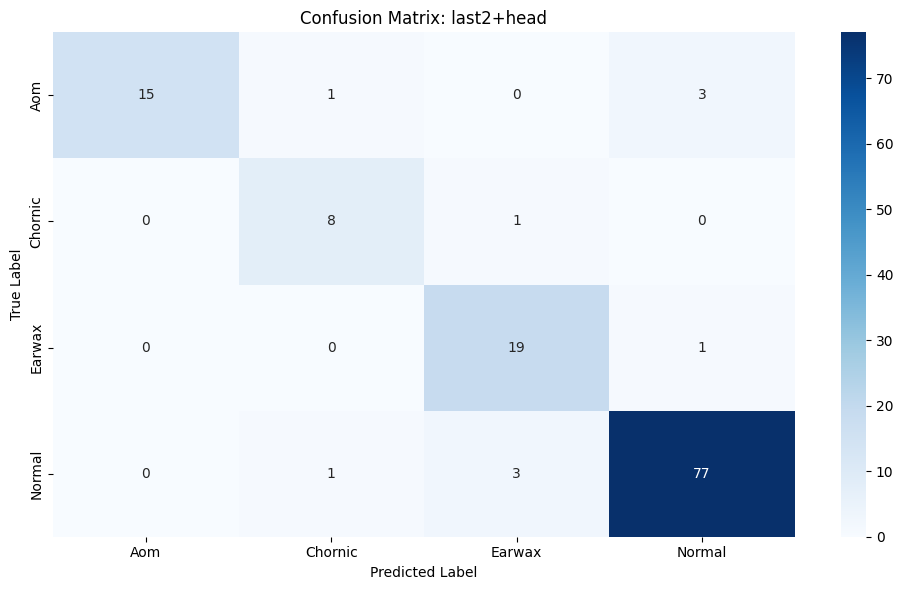


Evaluating strategy: last3+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/45604617e9614d3297ae658732b27ee5/checkpoints/last3+head-best-f1-epoch=05-val_f1=0.0654.ckpt

Accuracy:  0.2061
Precision: 0.1424
Recall:    0.0886
F1 Score (macro):  0.1056

F1 Score per class:
  Aom: 0.0556
  Chornic: 0.0800
  Earwax: 0.1176
  Normal: 0.3802

Classification Report:
              precision    recall  f1-score   support

         Aom       0.06      0.05      0.06        19
     Chornic       0.07      0.10      0.08        10
      Earwax       0.15      0.10      0.12        21
      Normal       0.57      0.28      0.38        81

   micro avg       0.32      0.21      0.25       131
   macro avg       0.21      0.13      0.16       131
weighted avg       0.39      0.21      0.27       131



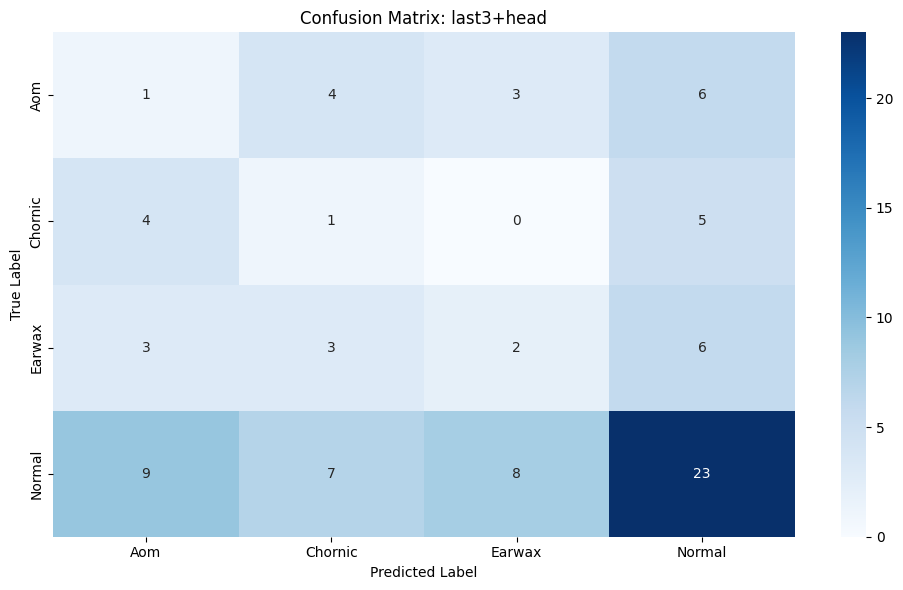


Evaluating strategy: last4+head
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/b4081fe9af994c2d913c065eb1987faa/checkpoints/last4+head-best-f1-epoch=02-val_f1=0.4643.ckpt

Accuracy:  0.9160
Precision: 0.7386
Recall:    0.7275
F1 Score (macro):  0.7313

F1 Score per class:
  Aom: 0.9143
  Chornic: 0.9524
  Earwax: 0.8571
  Normal: 0.9325

Classification Report:
              precision    recall  f1-score   support

         Aom       1.00      0.84      0.91        19
     Chornic       0.91      1.00      0.95        10
      Earwax       0.86      0.86      0.86        21
      Normal       0.93      0.94      0.93        81

   micro avg       0.92      0.92      0.92       131
   macro avg       0.92      0.91      0.91       131
weighted avg       0.92      0.92      0.92       131



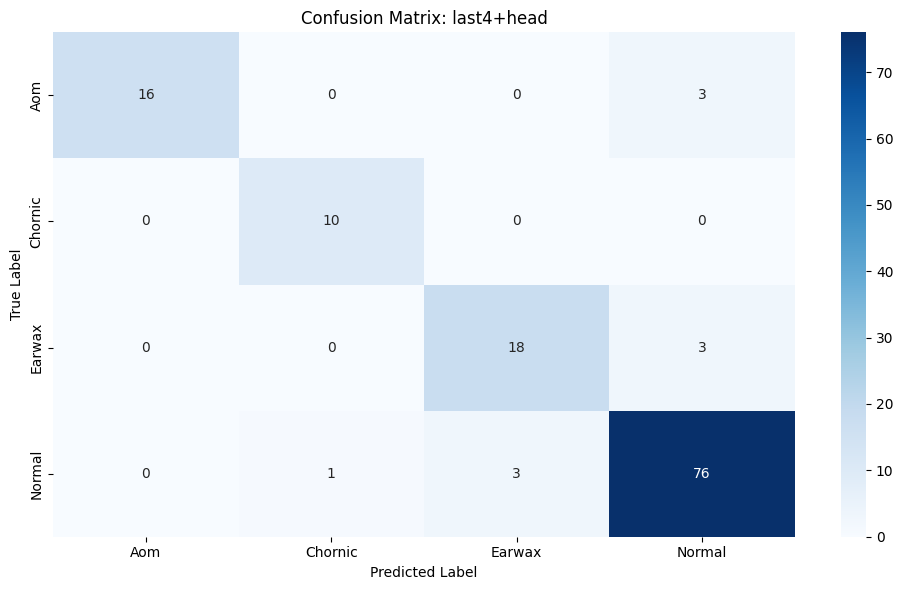


Evaluating strategy: full
Using device: mps
Loaded checkpoint: ///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/d94b6a98ea0e40529a9e7ba22adc1d3b/checkpoints/full-best-f1-epoch=00-val_f1=0.4171.ckpt

Accuracy:  0.7252
Precision: 0.5151
Recall:    0.3938
F1 Score (macro):  0.4145

F1 Score per class:
  Aom: 0.5806
  Chornic: 0.4615
  Earwax: 0.6275
  Normal: 0.8171

Classification Report:
              precision    recall  f1-score   support

         Aom       0.75      0.47      0.58        19
     Chornic       1.00      0.30      0.46        10
      Earwax       0.53      0.76      0.63        21
      Normal       0.81      0.83      0.82        81

   micro avg       0.74      0.73      0.73       131
   macro avg       0.77      0.59      0.62       131
weighted avg       0.77      0.73      0.73       131



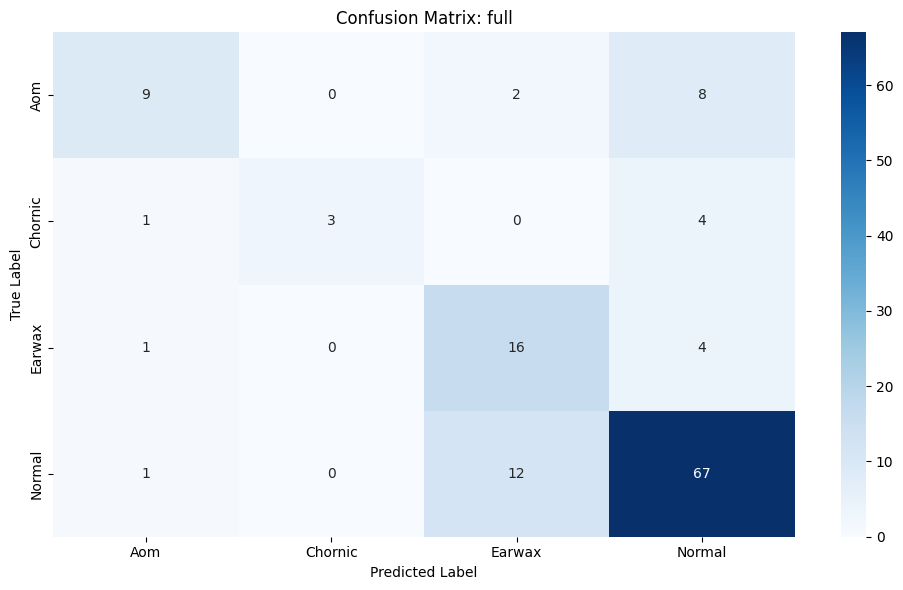

In [28]:
seed_everything(42, workers=True)

# ------------------- Reload Test Dataset -------------------
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root='eardrum_split/test', transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"\nLoaded test dataset with {len(test_dataset.classes)} classes: {test_dataset.classes}")

# ------------------- Set MLflow Tracking -------------------
tracking_uri = "file:///Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("eardrum_finetune_strategies")

# ------------------- Evaluation Function -------------------
def evaluate_model(strategy, ckpt_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"\nEvaluating strategy: {strategy}")
    print("Using device:", device)
    print("Loaded checkpoint:", ckpt_path)

    # Load model from checkpoint
    model = EfficientNetV2Lightning.load_from_checkpoint(ckpt_path)
    model = model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Always use fixed label list
    labels = list(range(len(test_dataset.classes)))

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, labels=labels, average=None, zero_division=0)

    print(f"\nAccuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score (macro):  {f1_macro:.4f}")

    print("\nF1 Score per class:")
    for idx, score in enumerate(f1_per_class):
        print(f"  {test_dataset.classes[idx]}: {score:.4f}")

    print("\nClassification Report:")
    report_txt = classification_report(
        all_labels,
        all_preds,
        labels=labels,
        target_names=test_dataset.classes,
        zero_division=0
    )
    print(report_txt)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix: {strategy}")
    plt.tight_layout()
    plt.show()

    # MLflow logging
    with mlflow.start_run(run_name=f"eval_{strategy}", nested=True):
        mlflow.log_param("strategy", strategy)
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", prec)
        mlflow.log_metric("test_recall", rec)
        mlflow.log_metric("test_f1_macro", f1_macro)

        # Log F1 scores per class
        for idx, score in enumerate(f1_per_class):
            class_metric_name = f"class_{test_dataset.classes[idx]}_f1"
            mlflow.log_metric(class_metric_name, score)

        # Save and log classification report
        report_path = f"classification_report_{strategy}.txt"
        with open(report_path, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(report_path)

        # Log model checkpoint used for evaluation
        mlflow.log_artifact(ckpt_path)

# ------------------- Load Latest best_checkpoints_*.json -------------------
checkpoint_files = glob.glob("best_checkpoints_*.json")
if not checkpoint_files:
    raise FileNotFoundError("No best_checkpoints_*.json files found.")

latest_ckpt_file = max(checkpoint_files, key=os.path.getmtime)
print(f"\nLoading latest checkpoint file: {latest_ckpt_file}")

with open(latest_ckpt_file, "r") as f:
    best_ckpt_paths = json.load(f)

# ------------------- Evaluate All Strategies -------------------
for strategy, ckpt_path in best_ckpt_paths.items():
    evaluate_model(strategy, ckpt_path)

## 18. Upload the Best Checkpoint to Google Drive

In [22]:
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from google.oauth2.credentials import Credentials

# Step 1: Define scopes and authenticate
SCOPES = ['https://www.googleapis.com/auth/drive.file']
creds = None

flow = InstalledAppFlow.from_client_secrets_file(
    'client_secrets.json', SCOPES)
creds = flow.run_local_server(port=0)

# Step 2: Build Drive service
drive_service = build('drive', 'v3', credentials=creds)

# Step 3: Define file to upload
file_path = "/Users/arturdvorak/Desktop/ML course/Notebooks/Image Recognision/mlruns/834690443400753513/46788dc38ee449f78f61e3e1e8b7b312/checkpoints/last2+head-best-f1-epoch=03-val_f1=0.4978.ckpt"
file_name = "best_model.ckpt"

# Step 4: Search for existing file with the same name
existing_files = drive_service.files().list(
    q=f"name='{file_name}' and trashed=false",
    fields="files(id, name)"
).execute()

# Step 5: Upload new or overwrite existing
media = MediaFileUpload(file_path, resumable=True)
if existing_files.get('files'):
    # Overwrite the first found file
    file_id = existing_files['files'][0]['id']
    updated_file = drive_service.files().update(
        fileId=file_id,
        media_body=media
    ).execute()
    print(f"File overwritten. ID: {updated_file.get('id')}")
else:
    # Upload new file
    file_metadata = {'name': file_name}
    uploaded_file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()
    print(f"File uploaded successfully. ID: {uploaded_file.get('id')}")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=428947052521-kl0avn9ic3t3n9s7u5c5v6osco4r5oib.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61636%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=I0BbGGe6reAVgQ76gwhDSMJkqnXSWj&access_type=offline
File overwritten. ID: 1YE2TYrruX4kVKtnwwXmXz7VKXCYjrVlf
Public URL: https://drive.google.com/file/d/1YE2TYrruX4kVKtnwwXmXz7VKXCYjrVlf/view?usp=sharing
